In [1]:
#Create Access to my code
import sys
sys.path.insert(1, '../vidr/')

#Import hte vaedr functions we have created
from vidr import VIDR
from utils import *

#Import important modules
import scanpy as sc
import scgen as scg
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import gseapy as gp
from scipy import stats
from scipy import linalg
from scipy import spatial
from anndata import AnnData
from scipy import sparse
from statannotations.Annotator import Annotator
from matplotlib import pyplot as plt

#For calculating statistical distance
import geomloss
import pykeops
import pykeops
pykeops.clean_pykeops()          # just in case old build files are still present
pykeops.test_numpy_bindings()    # perform the compilation

import scvi
sc.set_figure_params(dpi = 150)
sc.settings.figdir = "../figures"
sns.set_style("dark")

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[KeOps] /mnt/home/kanaomar/.cache/keops2.0/build_CUDA_VISIBLE_DEVICES_0_1_2_3 has been cleaned.
[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK
[KeOps] Generating code for formula Sum_Reduction((Var(0,3,0)-Var(1,3,1))|(Var(0,3,0)-Var(1,3,1)),1) ... OK
pyKeOps with numpy bindings is working!


In [2]:
adata = sc.read_h5ad("../data/nault2021_singleDose.h5ad")

In [3]:
#Prepare Data Set
cell_types_of_int = ["Hepatocytes - central", "Hepatocytes - portal", "Cholangiocytes", "Stellate Cells", "Portal Fibroblasts", "Endothelial Cells"]
adata = adata[adata.obs['celltype'].isin(cell_types_of_int)]

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=5000)

adata.obs["dose"] = [str(d) for d in adata.obs.Dose]
adata = adata[:,adata.var.highly_variable]


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [4]:
#Training model
cell = "Hepatocytes - portal"
train_adata, test_adata = prepare_data(adata, "celltype", "dose", cell, "30", normalized = True)
train_adata.obs["cell_dose"] = [f"{j}_{str(i)}" for (i,j) in zip(train_adata.obs["Dose"], train_adata.obs["celltype"])]
model = VIDR(train_adata, linear_decoder = False)
#     model.train(
#     max_epochs=100,
#     batch_size=128,
#     early_stopping=True,
#     early_stopping_patience=25)
    
#     model.save(f"../../data/VAE_Binary_Prediction_Dioxin_5000g_{cell}.pt")
vae = model.load(f"../../data/VAE_Binary_Prediction_Dioxin_5000g_{cell}.pt/", train_adata)

INFO     Using batches from adata.obs["dose"]                                                
INFO     Using labels from adata.obs["celltype"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 17791 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 17791 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


## Figure 2 A

In [5]:
#UMAP Projection of latent space
latent_X = vae.get_latent_representation(adata)
latent_adata = sc.AnnData(X=latent_X, obs=adata.obs.copy())
cell_dose = [f"{j}_{str(i)}" for (i,j) in zip(adata.obs["Dose"], adata.obs["celltype"])]
training = ["Train" if i != cell+"_30" else "Test" for i in cell_dose]
latent_adata.obs["Cell_Dose"] = cell_dose
latent_adata.obs["Training Split"] = training

INFO     Received view of anndata, making copy.                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 18865 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [6]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dose' as categorical
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Cell_Dose' as categorical
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future versio

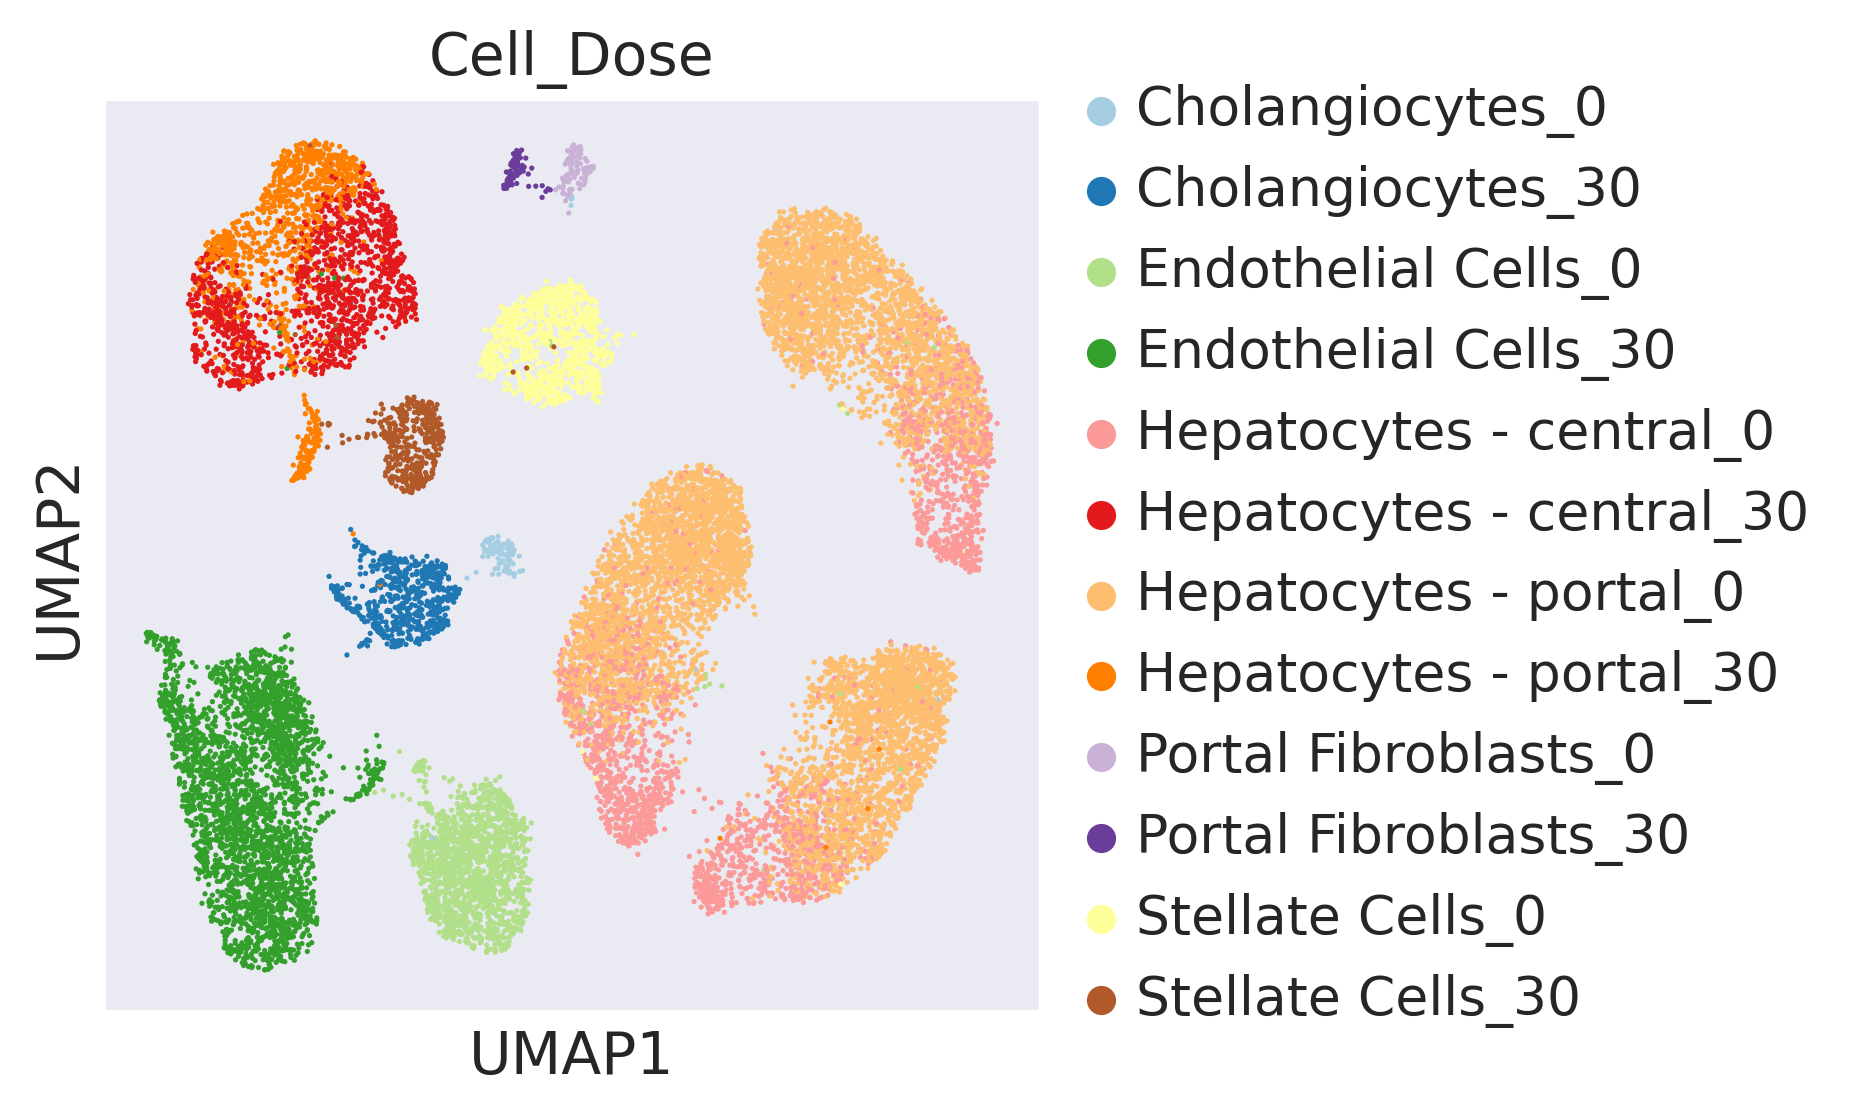

In [7]:
ax = sc.pl.umap(latent_adata, color=['Cell_Dose'], frameon=True,palette = "Paired", save ="2A1.svg")

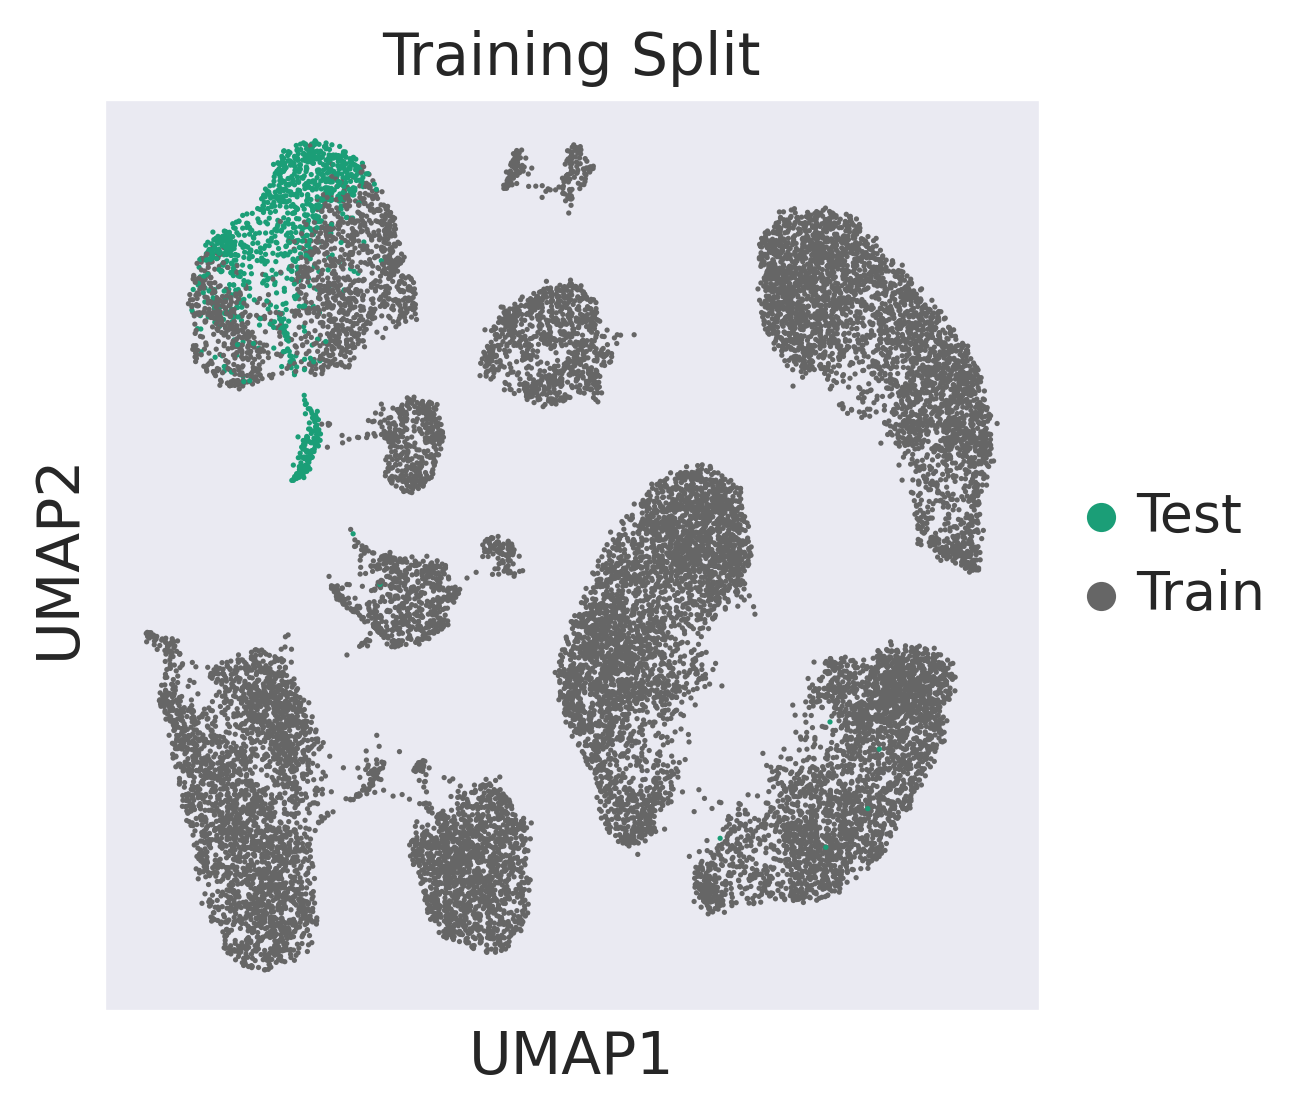

In [8]:
sc.pl.umap(latent_adata, color=['Training Split'], frameon=True,palette ="Dark2", save="2A2.svg")

## Figure 2B

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 2383 cells, 5000 vars, 2 batches, 
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 14260 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 14260 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/annda

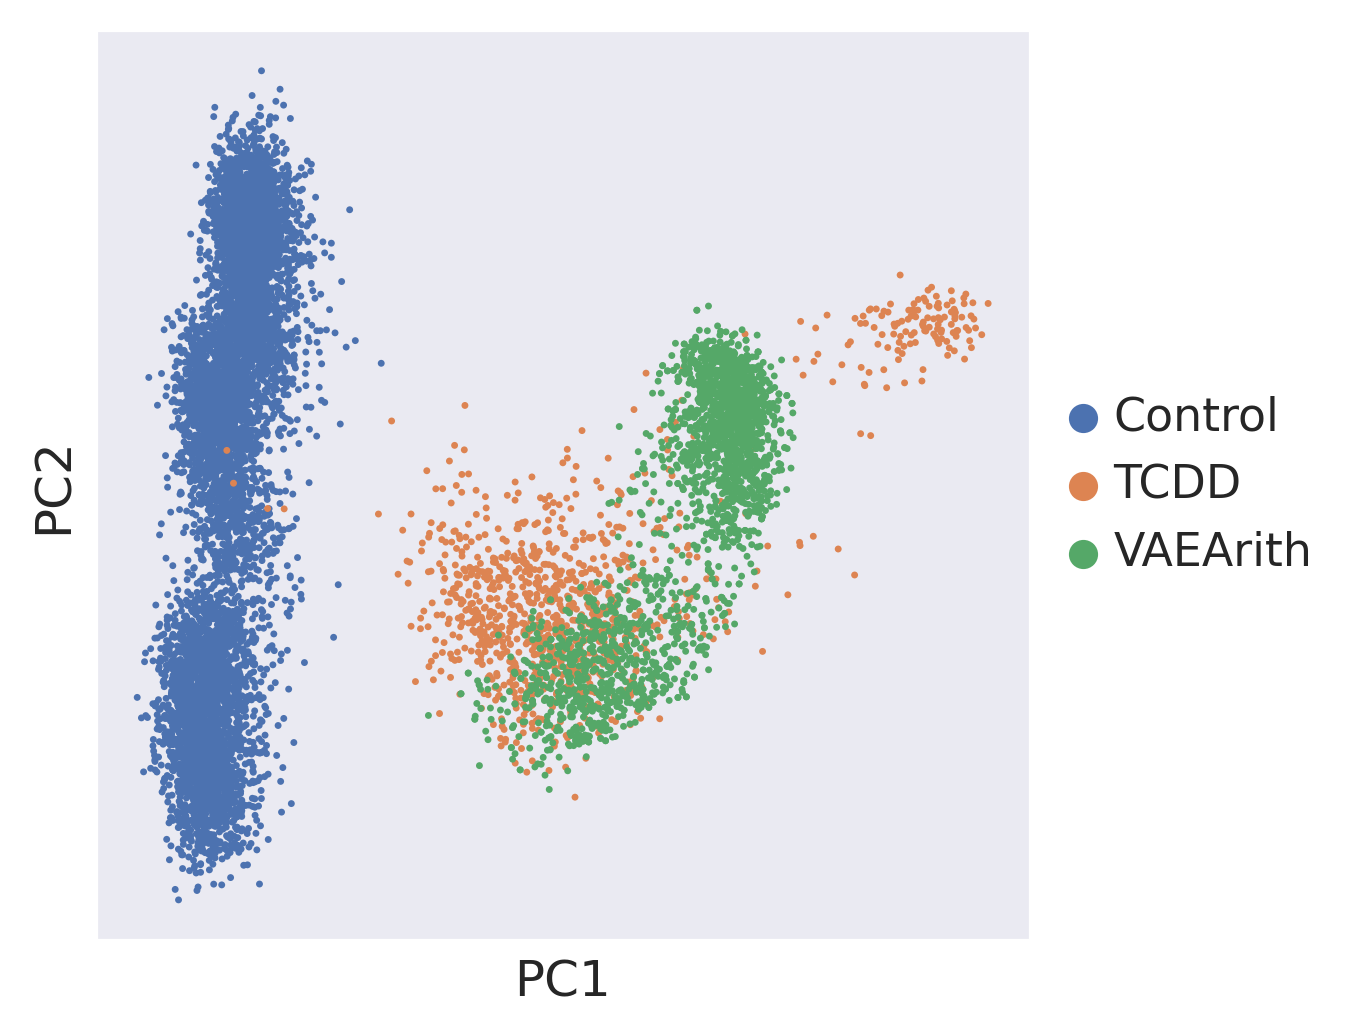

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dose' as categorical


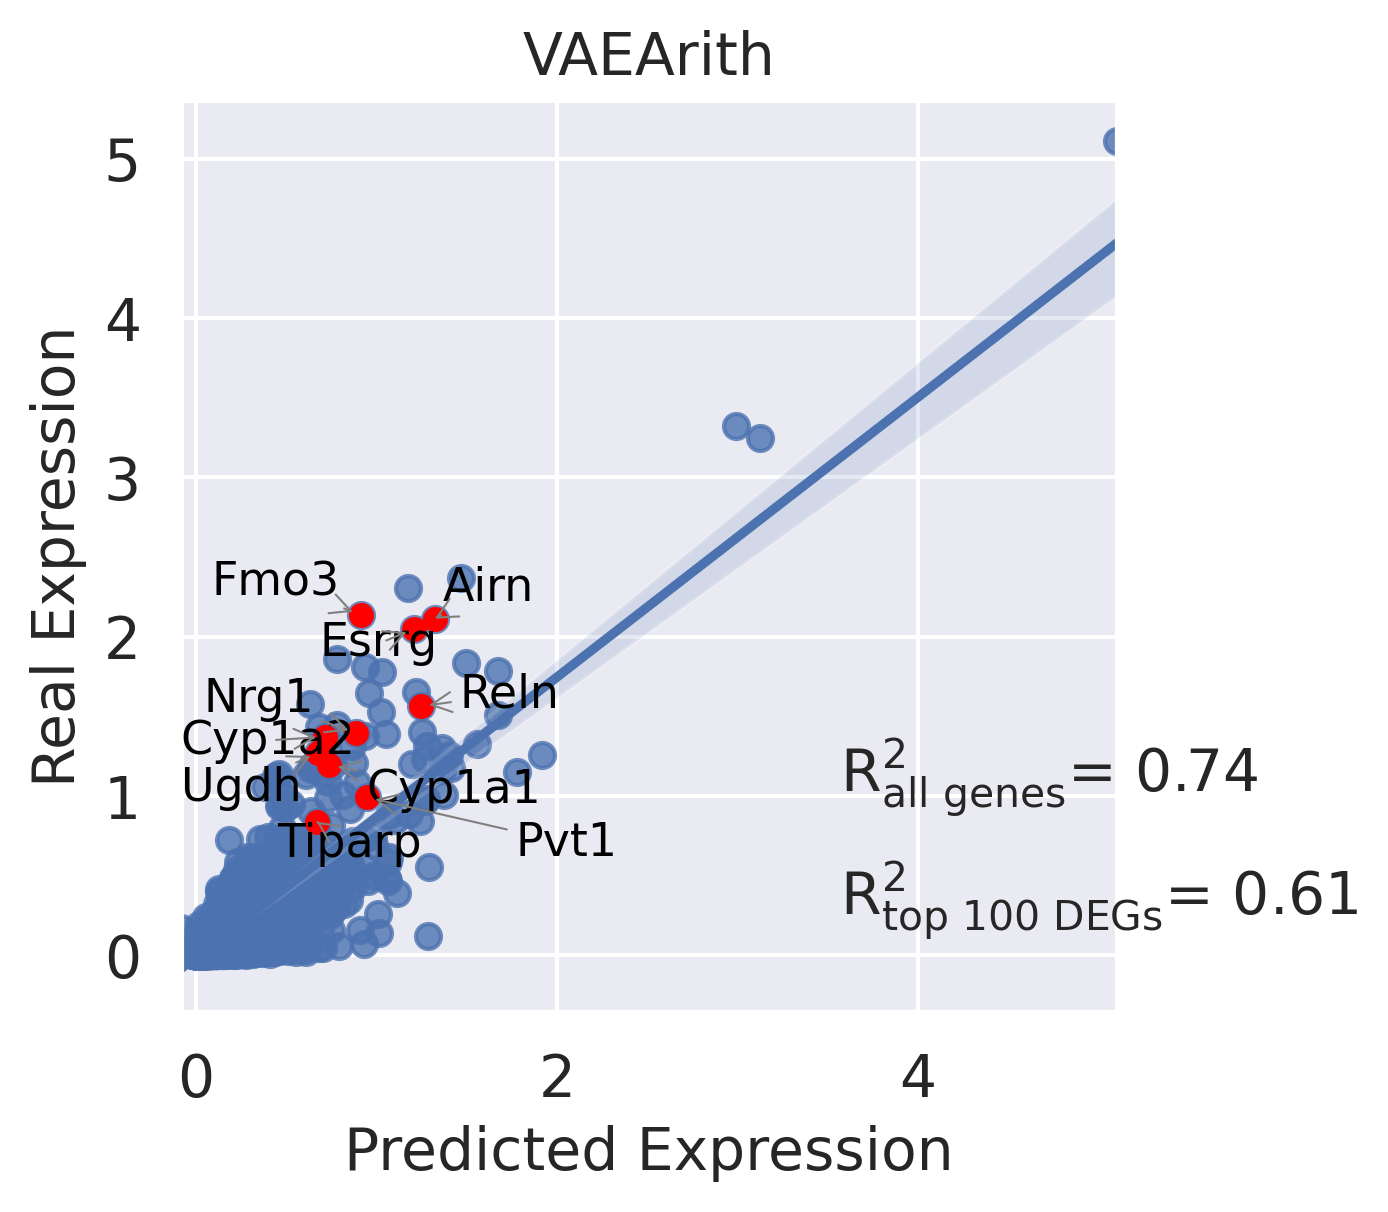

(0.7412729808604916, 0.6055730593169139)


In [10]:
model = vae
pred, delta = model.predict(
ctrl_key="0",
treat_key="30",
cell_type_to_predict=cell,
regression = False)
pred.obs["dose"] = 'pred'
ctrl_adata = adata[((adata.obs['celltype'] == cell) & (adata.obs["dose"] == "0"))]
treat_adata = adata[((adata.obs['celltype'] == cell) & (adata.obs["dose"] == "30"))]
eval_adata1 = ctrl_adata.concatenate(treat_adata, pred)
treatments = []
for i in eval_adata1.obs["dose"]:
    if i == "0":
        treatments.append("Control")
    elif i == "30":
        treatments.append("TCDD")
    else:
        treatments.append("VAEArith")
eval_adata1.obs["Treatment"] = treatments
sc.tl.pca(eval_adata1)
sc.pl.pca(eval_adata1, color = "Treatment", frameon = True, title = "", save = "2B1.svg")
CD4T = adata[adata.obs["celltype"] ==cell]
sc.tl.rank_genes_groups(CD4T, groupby="dose", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["30"]
r2_value = model.reg_mean_plot(
eval_adata1,
axis_keys={"x": "pred", "y": "30"},
gene_list=diff_genes[:10],
top_100_genes = diff_genes[:100],
labels={"x": "Predicted Expression", "y": "Real Expression"},
path_to_save="../figures/2B2.svg",
show=True,
legend=False, title = "VAEArith")
print(r2_value)

## Figure 2C

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 2347 cells, 5000 vars, 2 batches, 
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 28520 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'ce

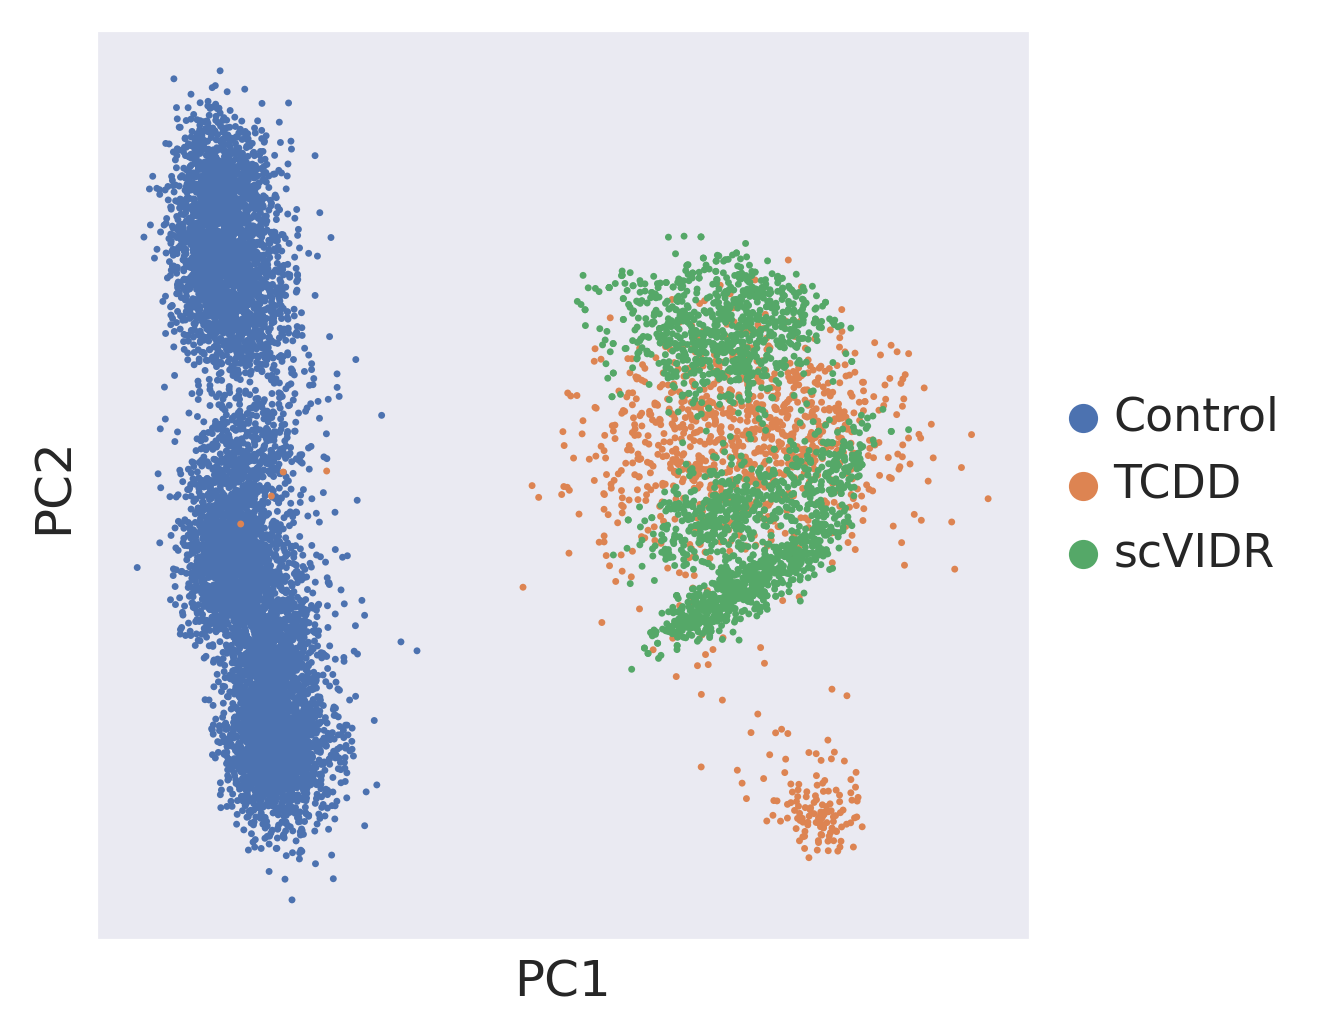

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dose' as categorical


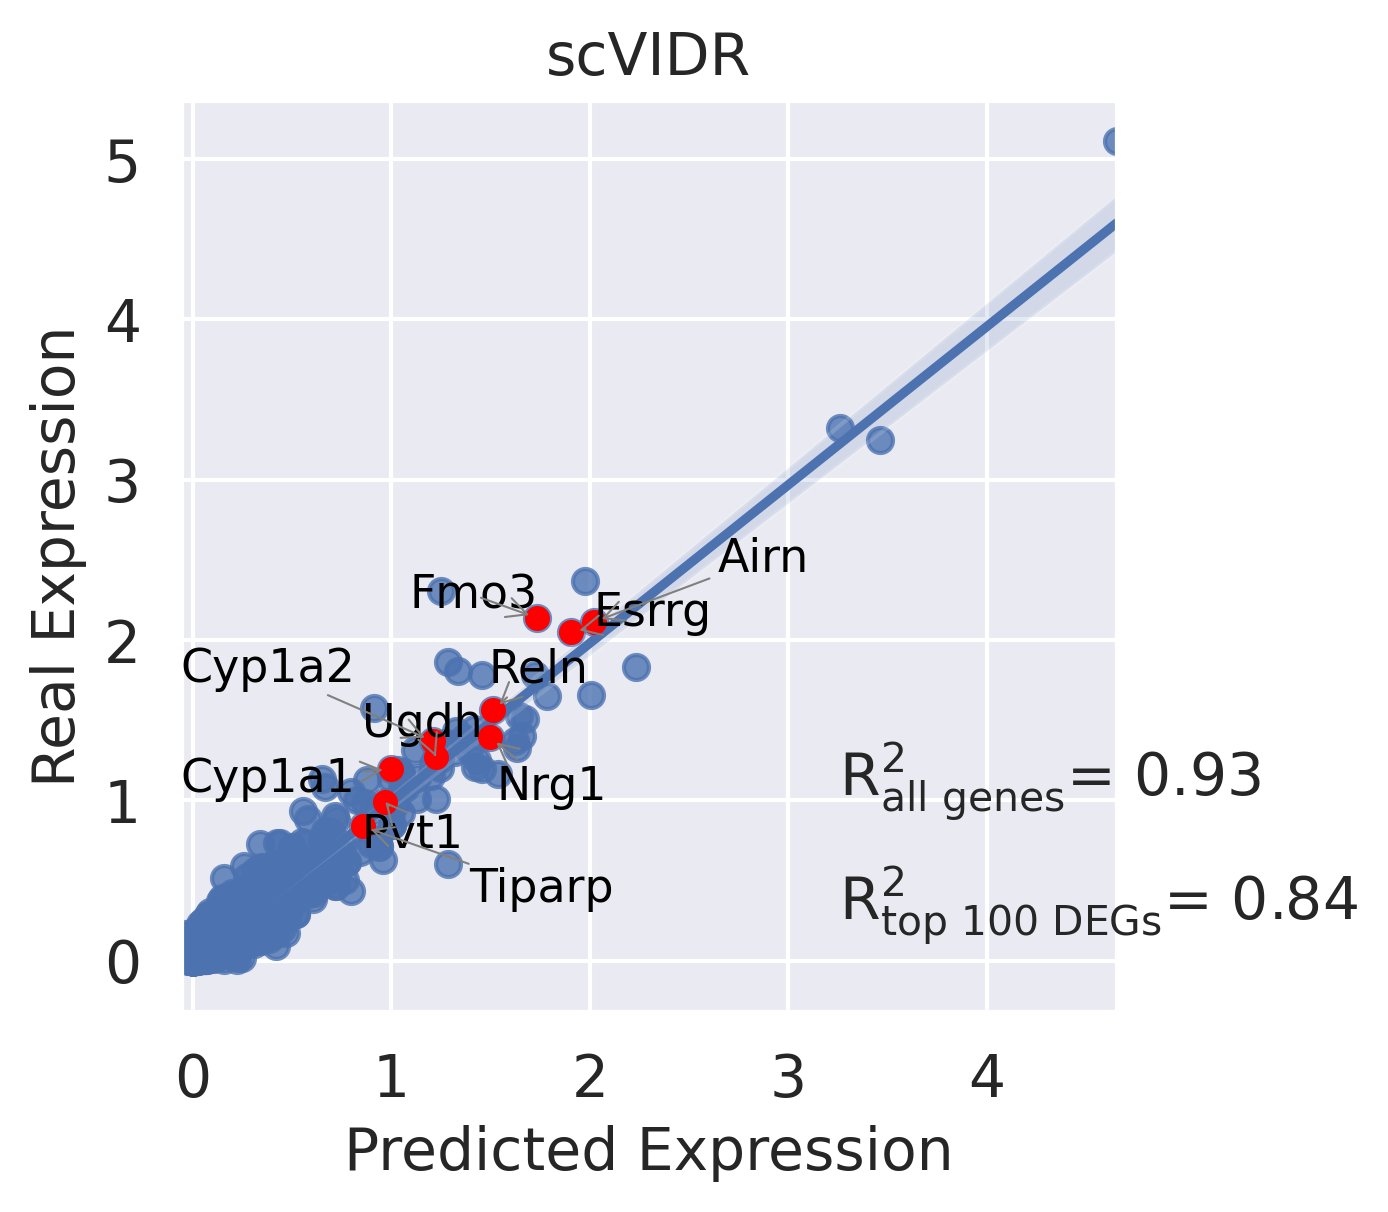

(0.9331575277168523, 0.8371578892235645)


In [11]:
model = vae
pred, delta, reg = model.predict(
ctrl_key="0",
treat_key="30",
cell_type_to_predict=cell,
regression = True)
pred.obs["dose"] = 'pred'
ctrl_adata = adata[((adata.obs['celltype'] == cell) & (adata.obs["dose"] == "0"))]
treat_adata = adata[((adata.obs['celltype'] == cell) & (adata.obs["dose"] == "30"))]
eval_adata2 = ctrl_adata.concatenate(treat_adata, pred)
treatments = []
for i in eval_adata2.obs["dose"]:
    if i == "0":
        treatments.append("Control")
    elif i == "30":
        treatments.append("TCDD")
    else:
        treatments.append("scVIDR")
eval_adata2.obs["Treatment"] = treatments
sc.tl.pca(eval_adata2)
sc.pl.pca(eval_adata2, color = "Treatment", frameon = True, title = "", save = "2C1.svg")
CD4T = adata[adata.obs["celltype"] ==cell]
sc.tl.rank_genes_groups(CD4T, groupby="dose", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["30"]
r2_value = model.reg_mean_plot(
eval_adata2,
axis_keys={"x": "pred", "y": "30"},
gene_list=diff_genes[:10],
top_100_genes = diff_genes[:100],
labels={"x": "Predicted Expression", "y": "Real Expression"},
path_to_save="../figures/Figure2C2.svg",
show=True,
legend=False, title = "scVIDR")
print(r2_value)

## Figure 2D

In [12]:
eval_adata = eval_adata1.concatenate(eval_adata2)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [13]:
eval_adata.obs

Dose batch              celltype  dose  \
AAACCCACAGTTAGGG_1-0-0-0       0     0  Hepatocytes - portal     0   
AAACCCAGTGCCTGCA_1-0-0-0       0     0  Hepatocytes - portal     0   
AAACGAACATAGAATG_1-0-0-0       0     0  Hepatocytes - portal     0   
AAACGAAGTCGATTAC_1-0-0-0       0     0  Hepatocytes - portal     0   
AAACGCTTCGGCATCG_1-0-0-0       0     0  Hepatocytes - portal     0   
...                          ...   ...                   ...   ...   
ATAGAGAAGGTCCCGT_3-0-0-2-1     0     1  Hepatocytes - portal  pred   
TTCCTTCTCTCCCAAC_3-0-0-2-1     0     1  Hepatocytes - portal  pred   
CAGCACGAGCTCCGAC_2-0-0-2-1     0     1  Hepatocytes - portal  pred   
AACCATGCAGGCCCTA_1-0-0-2-1     0     1  Hepatocytes - portal  pred   
CACGGGTTCGCACGAC_2-0-0-2-1     0     1  Hepatocytes - portal  pred   

                            _scvi_batch  _scvi_labels  _scvi_local_l_mean  \
AAACCCACAGTTAGGG_1-0-0-0            NaN           NaN                 NaN   
AAACCCAGTGCCTGCA_1-0-0-0            NaN           NaN                 NaN   
AAACGAACATAGAATG_1-0-0-0            NaN           NaN                 NaN   
AAACGAAGTCGATTAC_1-0-0-0            NaN           NaN                 NaN   
AAACGCTTCGGCATCG_1-0-0-0            NaN           NaN                 NaN   
...                                 ...           ...                 ...   
ATAGAGAAGGTCCCGT_3-0-0-2-1          0.0           3.0            5.716166   
TTCCTTCTCTCCCAAC_3-0-0-2-1          0.0           3.0            5.716166   
CAGCACGAGCTCCGAC_2-0-0-2-1          0.0           3.0            5.716166   
AACCATGCAGGCCCTA_1-0-0-2-1          0.0           3.0            5.716166   
CACGGGTTCGCACGAC_2-0-0-2-1          0.0           3.0            5.716166   

                            _scvi_local_l_var               cell_dose  \
AAACCCACAGTTAGGG_1-0-0-0                  NaN                     NaN   
AAACCCAGTGCCTGCA_1-0-0-0                  NaN                     NaN   
AAACGAACATAGAATG_1-0-0-0                  NaN                     NaN   
AAACGAAGTCGATTAC_1-0-0-0                  NaN                     NaN   
AAACGCTTCGGCATCG_1-0-0-0                  NaN                     NaN   
...                                       ...                     ...   
ATAGAGAAGGTCCCGT_3-0-0-2-1           0.067732  Hepatocytes - portal_0   
TTCCTTCTCTCCCAAC_3-0-0-2-1           0.067732  Hepatocytes - portal_0   
CAGCACGAGCTCCGAC_2-0-0-2-1           0.067732  Hepatocytes - portal_0   
AACCATGCAGGCCCTA_1-0-0-2-1           0.067732  Hepatocytes - portal_0   
CACGGGTTCGCACGAC_2-0-0-2-1           0.067732  Hepatocytes - portal_0   

                           Treatment  
AAACCCACAGTTAGGG_1-0-0-0     Control  
AAACCCAGTGCCTGCA_1-0-0-0     Control  
AAACGAACATAGAATG_1-0-0-0     Control  
AAACGAAGTCGATTAC_1-0-0-0     Control  
AAACGCTTCGGCATCG_1-0-0-0     Control  
...                              ...  
ATAGAGAAGGTCCCGT_3-0-0-2-1    scVIDR  
TTCCTTCTCTCCCAAC_3-0-0-2-1    scVIDR  
CAGCACGAGCTCCGAC_2-0-0-2-1    scVIDR  
AACCATGCAGGCCCTA_1-0-0-2-1    scVIDR  
CACGGGTTCGCACGAC_2-0-0-2-1    scVIDR  

[21902 rows x 10 columns]

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Treatment' as categorical


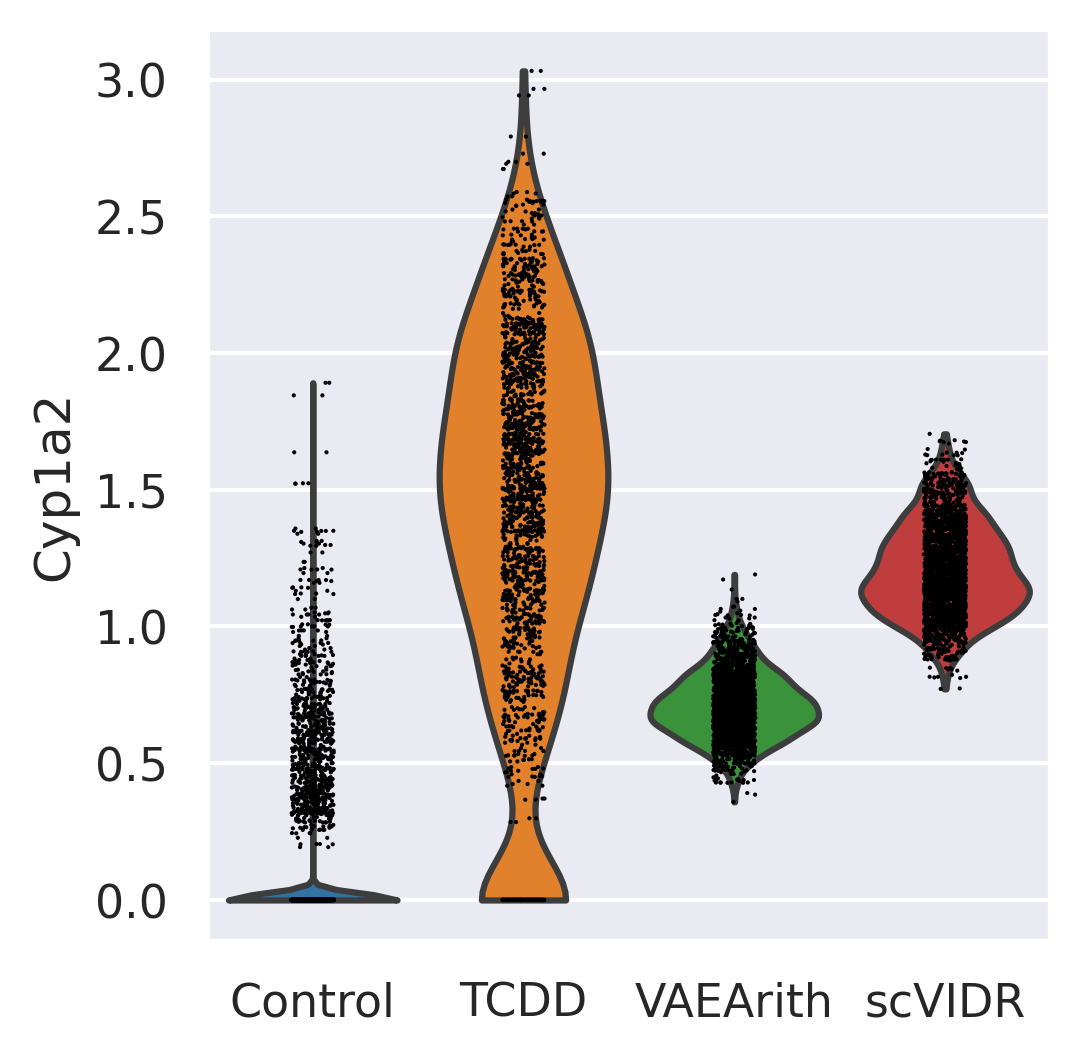

In [14]:
ax = sc.pl.violin(eval_adata, ["Cyp1a2"], groupby = "Treatment", rotation = 0, palette = "tab10", save = "2D.svg")

# Figure 2E

In [5]:
df_list = []
celltypes = np.unique(adata.obs["celltype"])
for cell in celltypes:
    print(cell)
    train_adata, test_adata = prepare_data(adata, "celltype", "dose", cell, "30", normalized = True)

    model = VIDR(train_adata, linear_decoder = False)
    model.train(
    max_epochs=100,
    batch_size=128,
    early_stopping=True,
    early_stopping_patience=25)
    
    model.save(f"../data/VAE_Binary_Prediction_Dioxin_5000g_{cell}.pt", overwrite = True)
    model = model.load(f"../data/VAE_Binary_Prediction_Dioxin_5000g_{cell}.pt/", train_adata)
    
    model_name = "VAEArith"
    
    pred, delta = model.predict(
    ctrl_key="0",
    treat_key="30",
    cell_type_to_predict=cell,
    regression = False)
    
    pred.obs["dose"] = 'pred'
    ctrl_adata = adata[((adata.obs['celltype'] == cell) & (adata.obs["dose"] == "0"))]
    treat_adata = adata[((adata.obs['celltype'] == cell) & (adata.obs["dose"] == "30"))]
    eval_adata = ctrl_adata.concatenate(treat_adata, pred)
    
    CD4T = adata[adata.obs["celltype"] ==cell]
    sc.tl.rank_genes_groups(CD4T, groupby="dose", method="wilcoxon")
    diff_genes = CD4T.uns["rank_genes_groups"]["names"]["30"]
    
    r2_df = calculate_r2_singledose(
        eval_adata, cell,
        model_name, 
        "dose", 
        {"x":"pred", "y":"30"}, 
        diff_genes=diff_genes[:100], 
        random_sample_coef = 0.8,
        n_iter = 500
    )
    df_list.append(r2_df)

Cholangiocytes
INFO     Using batches from adata.obs["dose"]                                                
INFO     Using labels from adata.obs["celltype"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 18265 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Set SLURM handle signals.


None
Epoch 39/100:  39%|███▉      | 39/100 [03:19<05:12,  5.12s/it, loss=108, v_num=1]
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 18265 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 2415 cells, 5000 vars, 2 batches, 
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 14260 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModi

Endothelial Cells
INFO     Using batches from adata.obs["dose"]                                                
INFO     Using labels from adata.obs["celltype"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 16013 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Set SLURM handle signals.


None
Epoch 33/100:  33%|███▎      | 33/100 [01:12<02:26,  2.19s/it, loss=93.2, v_num=1]
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 16013 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1101 cells, 5000 vars, 2 batches, 
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 6625 cells, 5000 vars, 2 batches, 
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 6625 cells, 5000 vars, 2 batches, 
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModi

Hepatocytes - central
INFO     Using batches from adata.obs["dose"]                                                
INFO     Using labels from adata.obs["celltype"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 17540 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Set SLURM handle signals.


Epoch 41/100:  41%|████      | 41/100 [02:55<04:12,  4.27s/it, loss=111, v_num=1]
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 17540 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 2341 cells, 5000 vars, 2 batches, 
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 14260 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 14260 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModi

Hepatocytes - portal
INFO     Using batches from adata.obs["dose"]                                                
INFO     Using labels from adata.obs["celltype"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 17791 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Set SLURM handle signals.


Epoch 33/100:  33%|███▎      | 33/100 [01:19<02:42,  2.42s/it, loss=111, v_num=1]
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 17791 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 2368 cells, 5000 vars, 2 batches, 
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 14260 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModi

Portal Fibroblasts
INFO     Using batches from adata.obs["dose"]                                                
INFO     Using labels from adata.obs["celltype"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 18789 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Set SLURM handle signals.


Epoch 33/100:  33%|███▎      | 33/100 [01:49<03:43,  3.33s/it, loss=112, v_num=1]
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 18789 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 2404 cells, 5000 vars, 2 batches, 
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 14260 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 14260 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModi

Stellate Cells
INFO     Using batches from adata.obs["dose"]                                                
INFO     Using labels from adata.obs["celltype"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 18474 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Set SLURM handle signals.


Epoch 34/100:  34%|███▍      | 34/100 [02:38<05:07,  4.66s/it, loss=108, v_num=1]
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 18474 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 2389 cells, 5000 vars, 2 batches, 
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 14260 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 14260 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModi

In [6]:
for cell in celltypes:
    print(cell)
    train_adata, test_adata = prepare_data(adata, "celltype", "dose", cell, "30", normalized = True)

    model = VIDR(train_adata, linear_decoder = False)
#     model.train(
#     max_epochs=100,
#     batch_size=128,
#     early_stopping=True,
#     early_stopping_patience=25)
    
#     model.save(f"../../data/VAE_Binary_Prediction_Dioxin_5000g_{cell}.pt")
    model = model.load(f"../../data/VAE_Binary_Prediction_Dioxin_5000g_{cell}.pt/", train_adata)
    
    model_name = "scVIDR"
    
    pred, delta, reg = model.predict(
    ctrl_key="0",
    treat_key="30",
    cell_type_to_predict=cell,
    regression = True)
    
    pred.obs["dose"] = 'pred'
    ctrl_adata = adata[((adata.obs['celltype'] == cell) & (adata.obs["dose"] == "0"))]
    treat_adata = adata[((adata.obs['celltype'] == cell) & (adata.obs["dose"] == "30"))]
    eval_adata = ctrl_adata.concatenate(treat_adata, pred)
    
    CD4T = adata[adata.obs["celltype"] ==cell]
    sc.tl.rank_genes_groups(CD4T, groupby="dose", method="wilcoxon")
    diff_genes = CD4T.uns["rank_genes_groups"]["names"]["30"]
    
    r2_df = calculate_r2_singledose(
        eval_adata, cell,
        model_name, 
        "dose", 
        {"x":"pred", "y":"30"}, 
        diff_genes=diff_genes[:100], 
        random_sample_coef = 0.8,
        n_iter = 500
    )
    df_list.append(r2_df)

Cholangiocytes
INFO     Using batches from adata.obs["dose"]                                                
INFO     Using labels from adata.obs["celltype"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 18265 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 18265 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 2455 cells, 5000 vars, 2 batches, 
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanao

Endothelial Cells
INFO     Using batches from adata.obs["dose"]                                                
INFO     Using labels from adata.obs["celltype"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 16013 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 16013 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1050 cells, 5000 vars, 2 batches, 
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 13250 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... 

Hepatocytes - central
INFO     Using batches from adata.obs["dose"]                                                
INFO     Using labels from adata.obs["celltype"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 17540 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 17540 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 2396 cells, 5000 vars, 2 batches, 
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 28520 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanao

Hepatocytes - portal
INFO     Using batches from adata.obs["dose"]                                                
INFO     Using labels from adata.obs["celltype"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 17791 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 17791 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 2402 cells, 5000 vars, 2 batches, 
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanao

Portal Fibroblasts
INFO     Using batches from adata.obs["dose"]                                                
INFO     Using labels from adata.obs["celltype"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 18789 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 18789 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 2376 cells, 5000 vars, 2 batches, 
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 28520 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... 

Stellate Cells
INFO     Using batches from adata.obs["dose"]                                                
INFO     Using labels from adata.obs["celltype"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 18474 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 18474 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 2357 cells, 5000 vars, 2 batches, 
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 28520 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanao

In [7]:
r2_values_allCells_df = pd.concat(df_list)

In [14]:
r2_values_allCells_df.to_csv("../data/SingleDose_Model_Results.csv")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

scVIDR_All HVGs vs. VAEArith_All HVGs: Mann-Whitney-Wilcoxon test greater, P_val:0.000e+00 U_stat=8.716e+06
scVIDR_DEGs vs. VAEArith_DEGs: Mann-Whitney-Wilcoxon test greater, P_val:0.000e+00 U_stat=8.079e+06


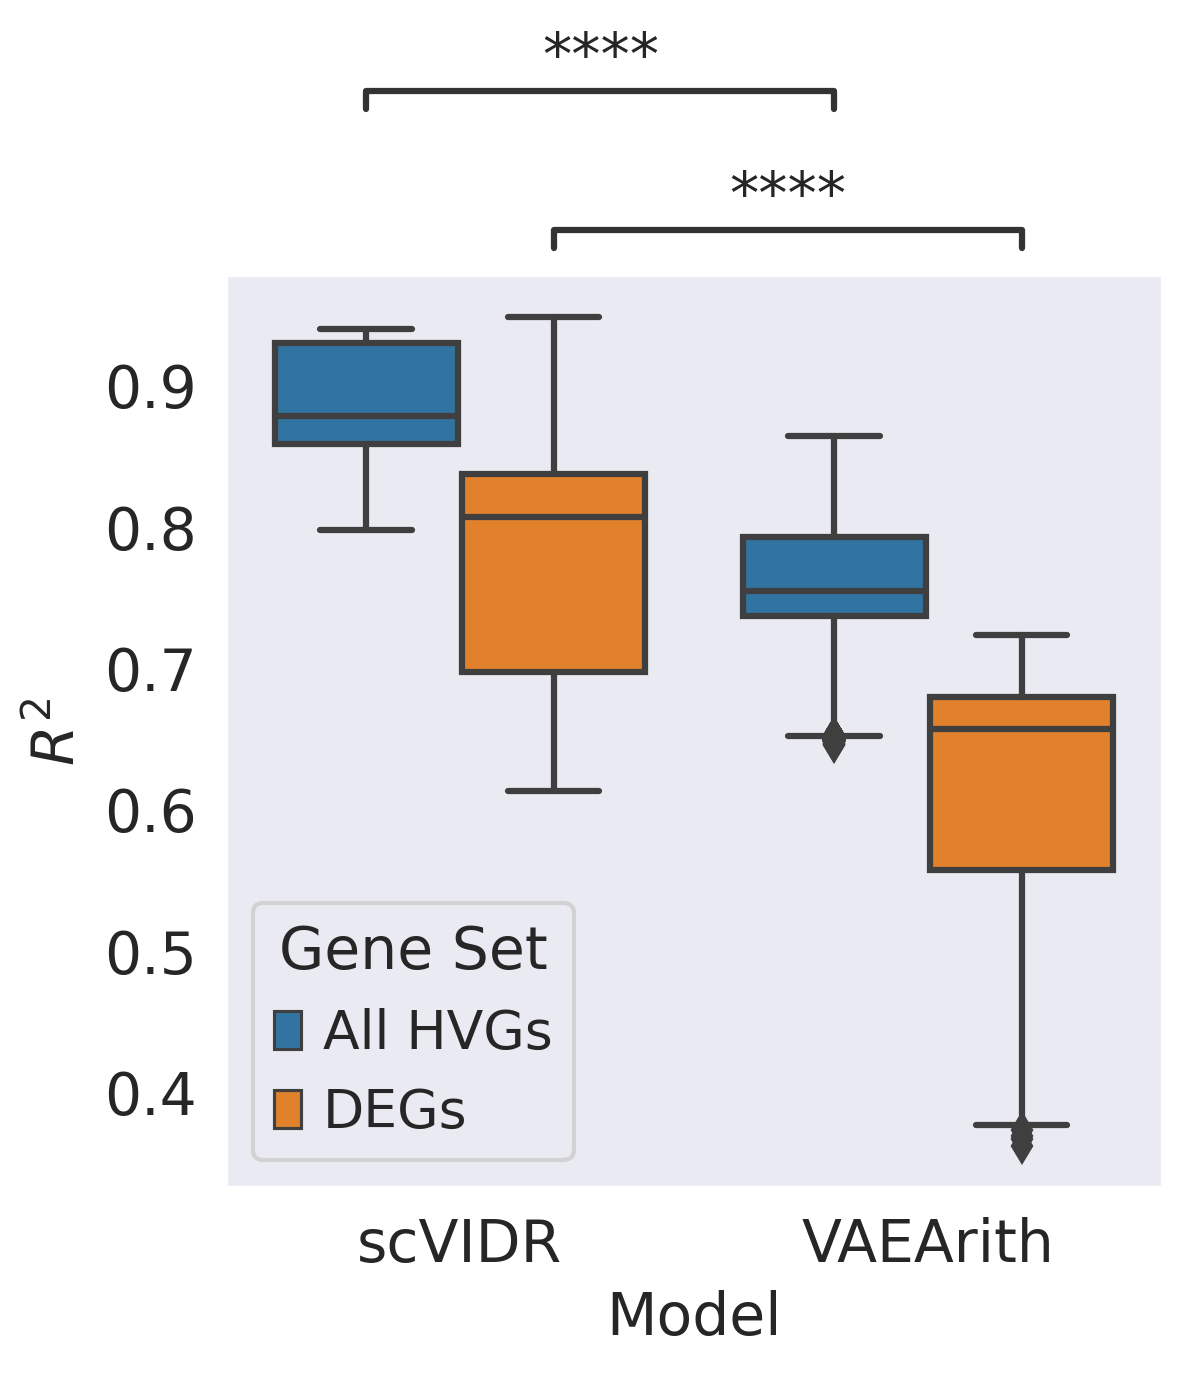

In [11]:
order = ['scVIDR', 'VAEArith']
hue_order = ["All HVGs", "DEGs"]
ax = sns.boxplot(x = "Model", y = "R^2",  data = r2_values_allCells_df, hue = "Gene Set", order = order, hue_order = hue_order)
pairs = [
    (('scVIDR','All HVGs'), ('VAEArith', 'All HVGs')),
    (('scVIDR','DEGs'), ('VAEArith', 'DEGs'))
]
annotator = Annotator(ax, pairs, data=r2_values_allCells_df, x="Model", y="R^2", hue = "Gene Set", order = order)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside')
annotator.apply_and_annotate()
plt.ylabel(r"$R^2$")
plt.savefig("../figures/Figure2E.svg", bbox_inches = "tight")
plt.show()

In [12]:
df = r2_values_allCells_df[r2_values_allCells_df["Gene Set"] == "DEGs"]

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Cholangiocytes'),
  Text(1, 0, 'Endothelial Cells'),
  Text(2, 0, 'Hepatocytes - central'),
  Text(3, 0, 'Hepatocytes - portal'),
  Text(4, 0, 'Portal Fibroblasts'),
  Text(5, 0, 'Stellate Cells')])

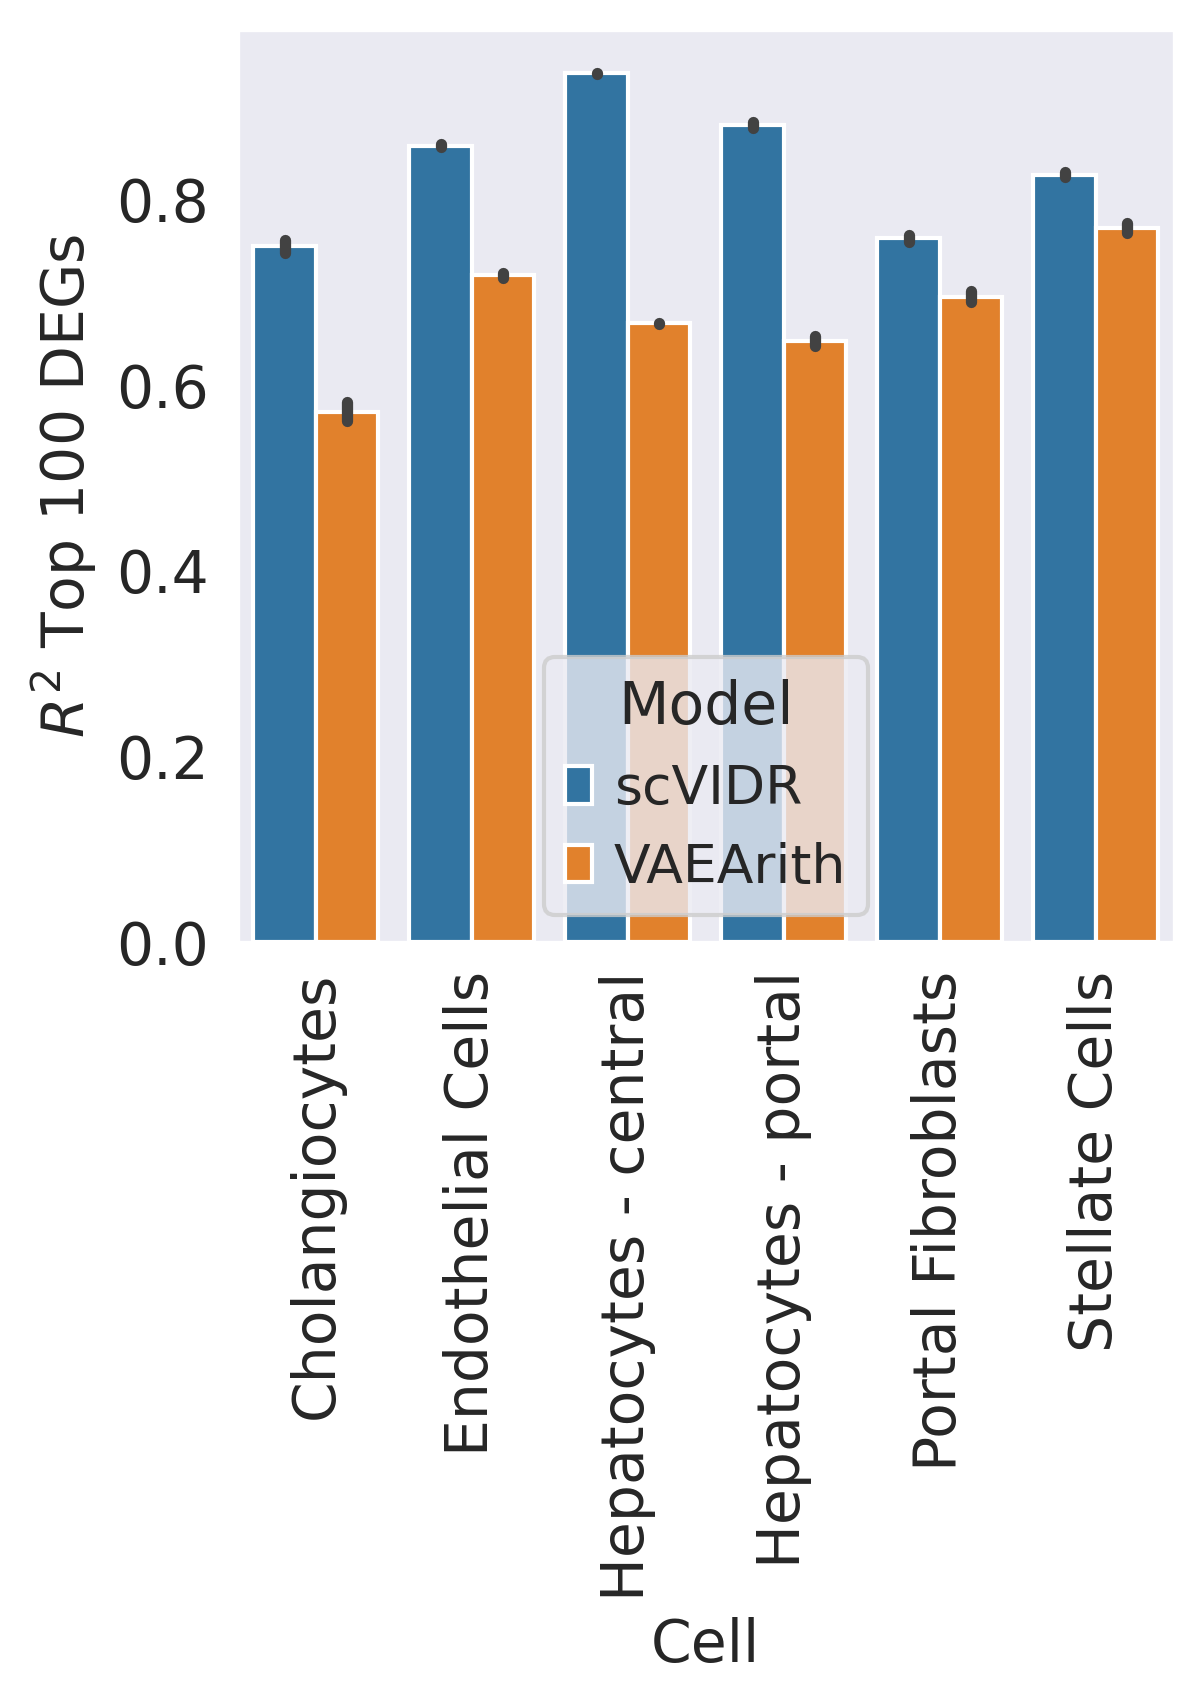

In [13]:
order = ['scVIDR', 'VAEArith']
hue_order = ["All HVGs", "DEGs"]
ax = sns.barplot(x = "Cell", y = "R^2",  data = r2_values_allCells_df, hue = "Model", hue_order=order)
plt.ylabel("$R^2$ Top 100 DEGs")
plt.xticks(rotation = 90)

In [ ]:
for cell in celltypes:
    print(cell)
    
    CD4T = adata[adata.obs["celltype"] ==cell]
    sc.tl.rank_genes_groups(CD4T, groupby="dose", method="wilcoxon")
    diff_genes = CD4T.uns["rank_genes_groups"]["names"]["30"]
    glist = diff_genes[:100]
    CD4T.

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, cop

Cholangiocytes
['Abcc4' '2610035D17Rik' 'Reln' 'Cyp1a1' 'Zfp981' 'Chd9' 'Atp1a1' 'Arap2'
 'Mmp7' 'Cyfip2']


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


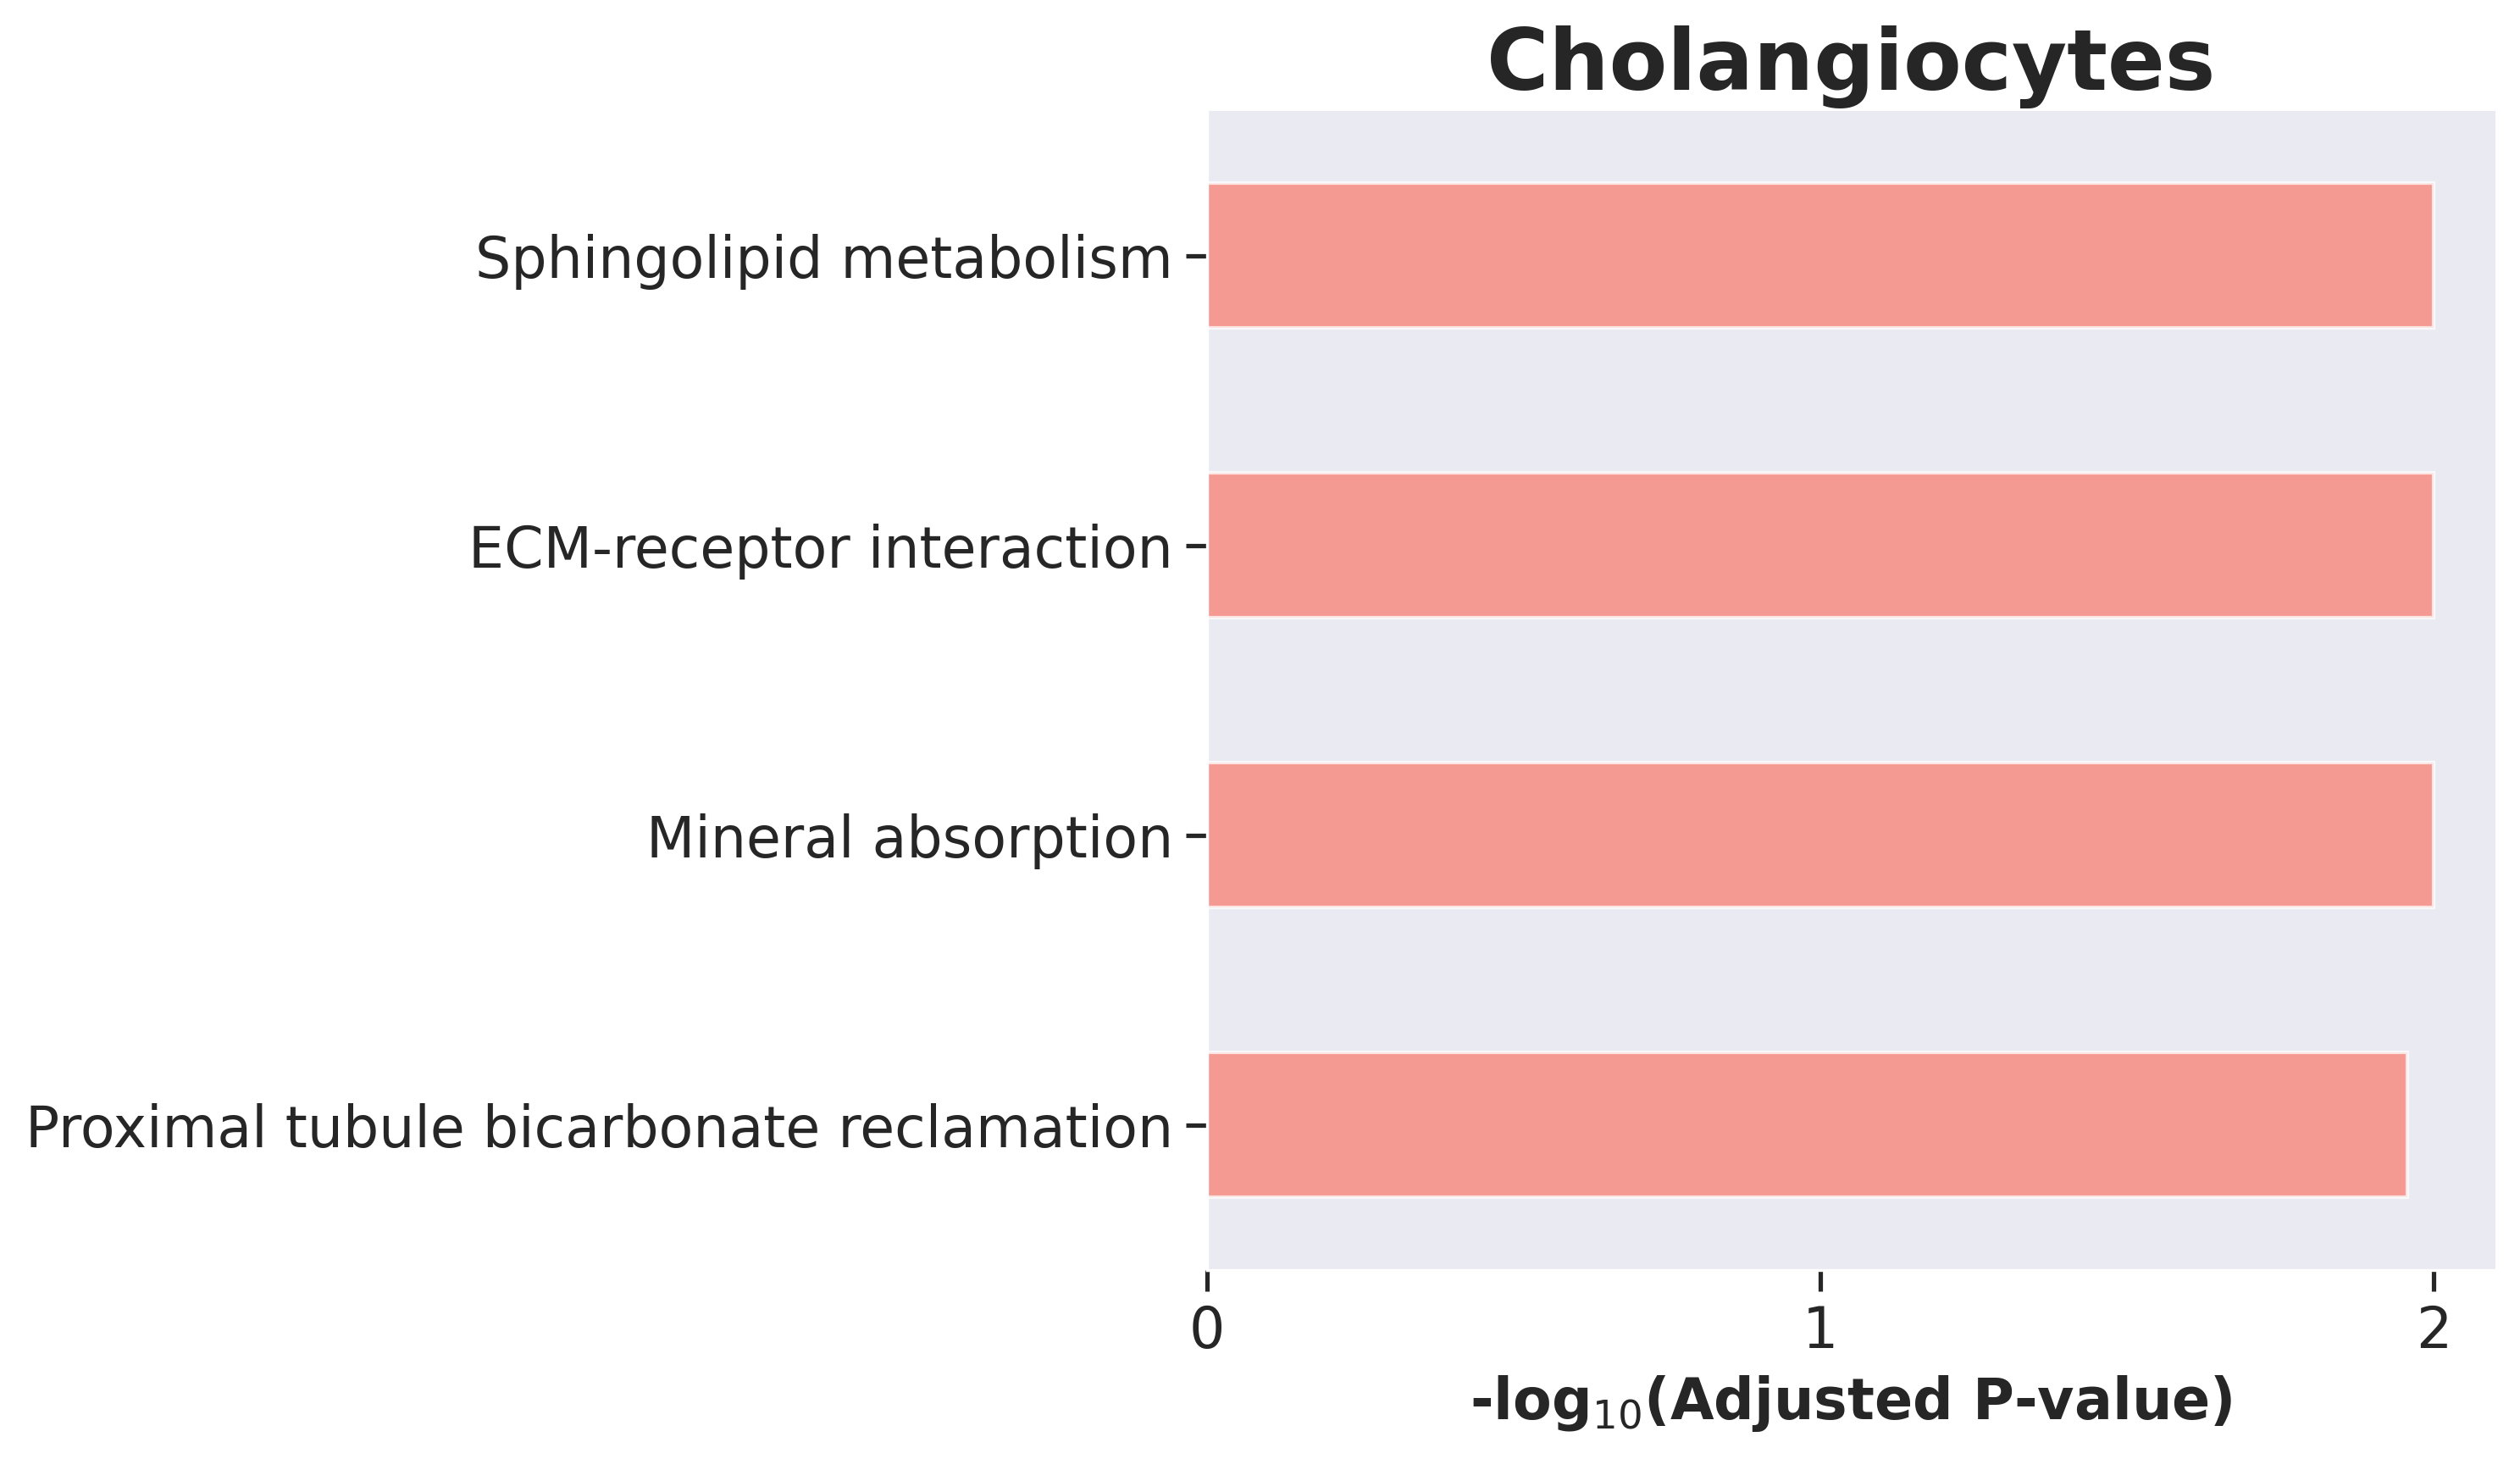

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, cop

Endothelial Cells
['Cyp1a1' 'Hgf' 'Sdk1' 'Abi1' 'Gab2' 'Meis2' 'Adam23' 'Acer2' 'Il1r1'
 'Jam2']


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


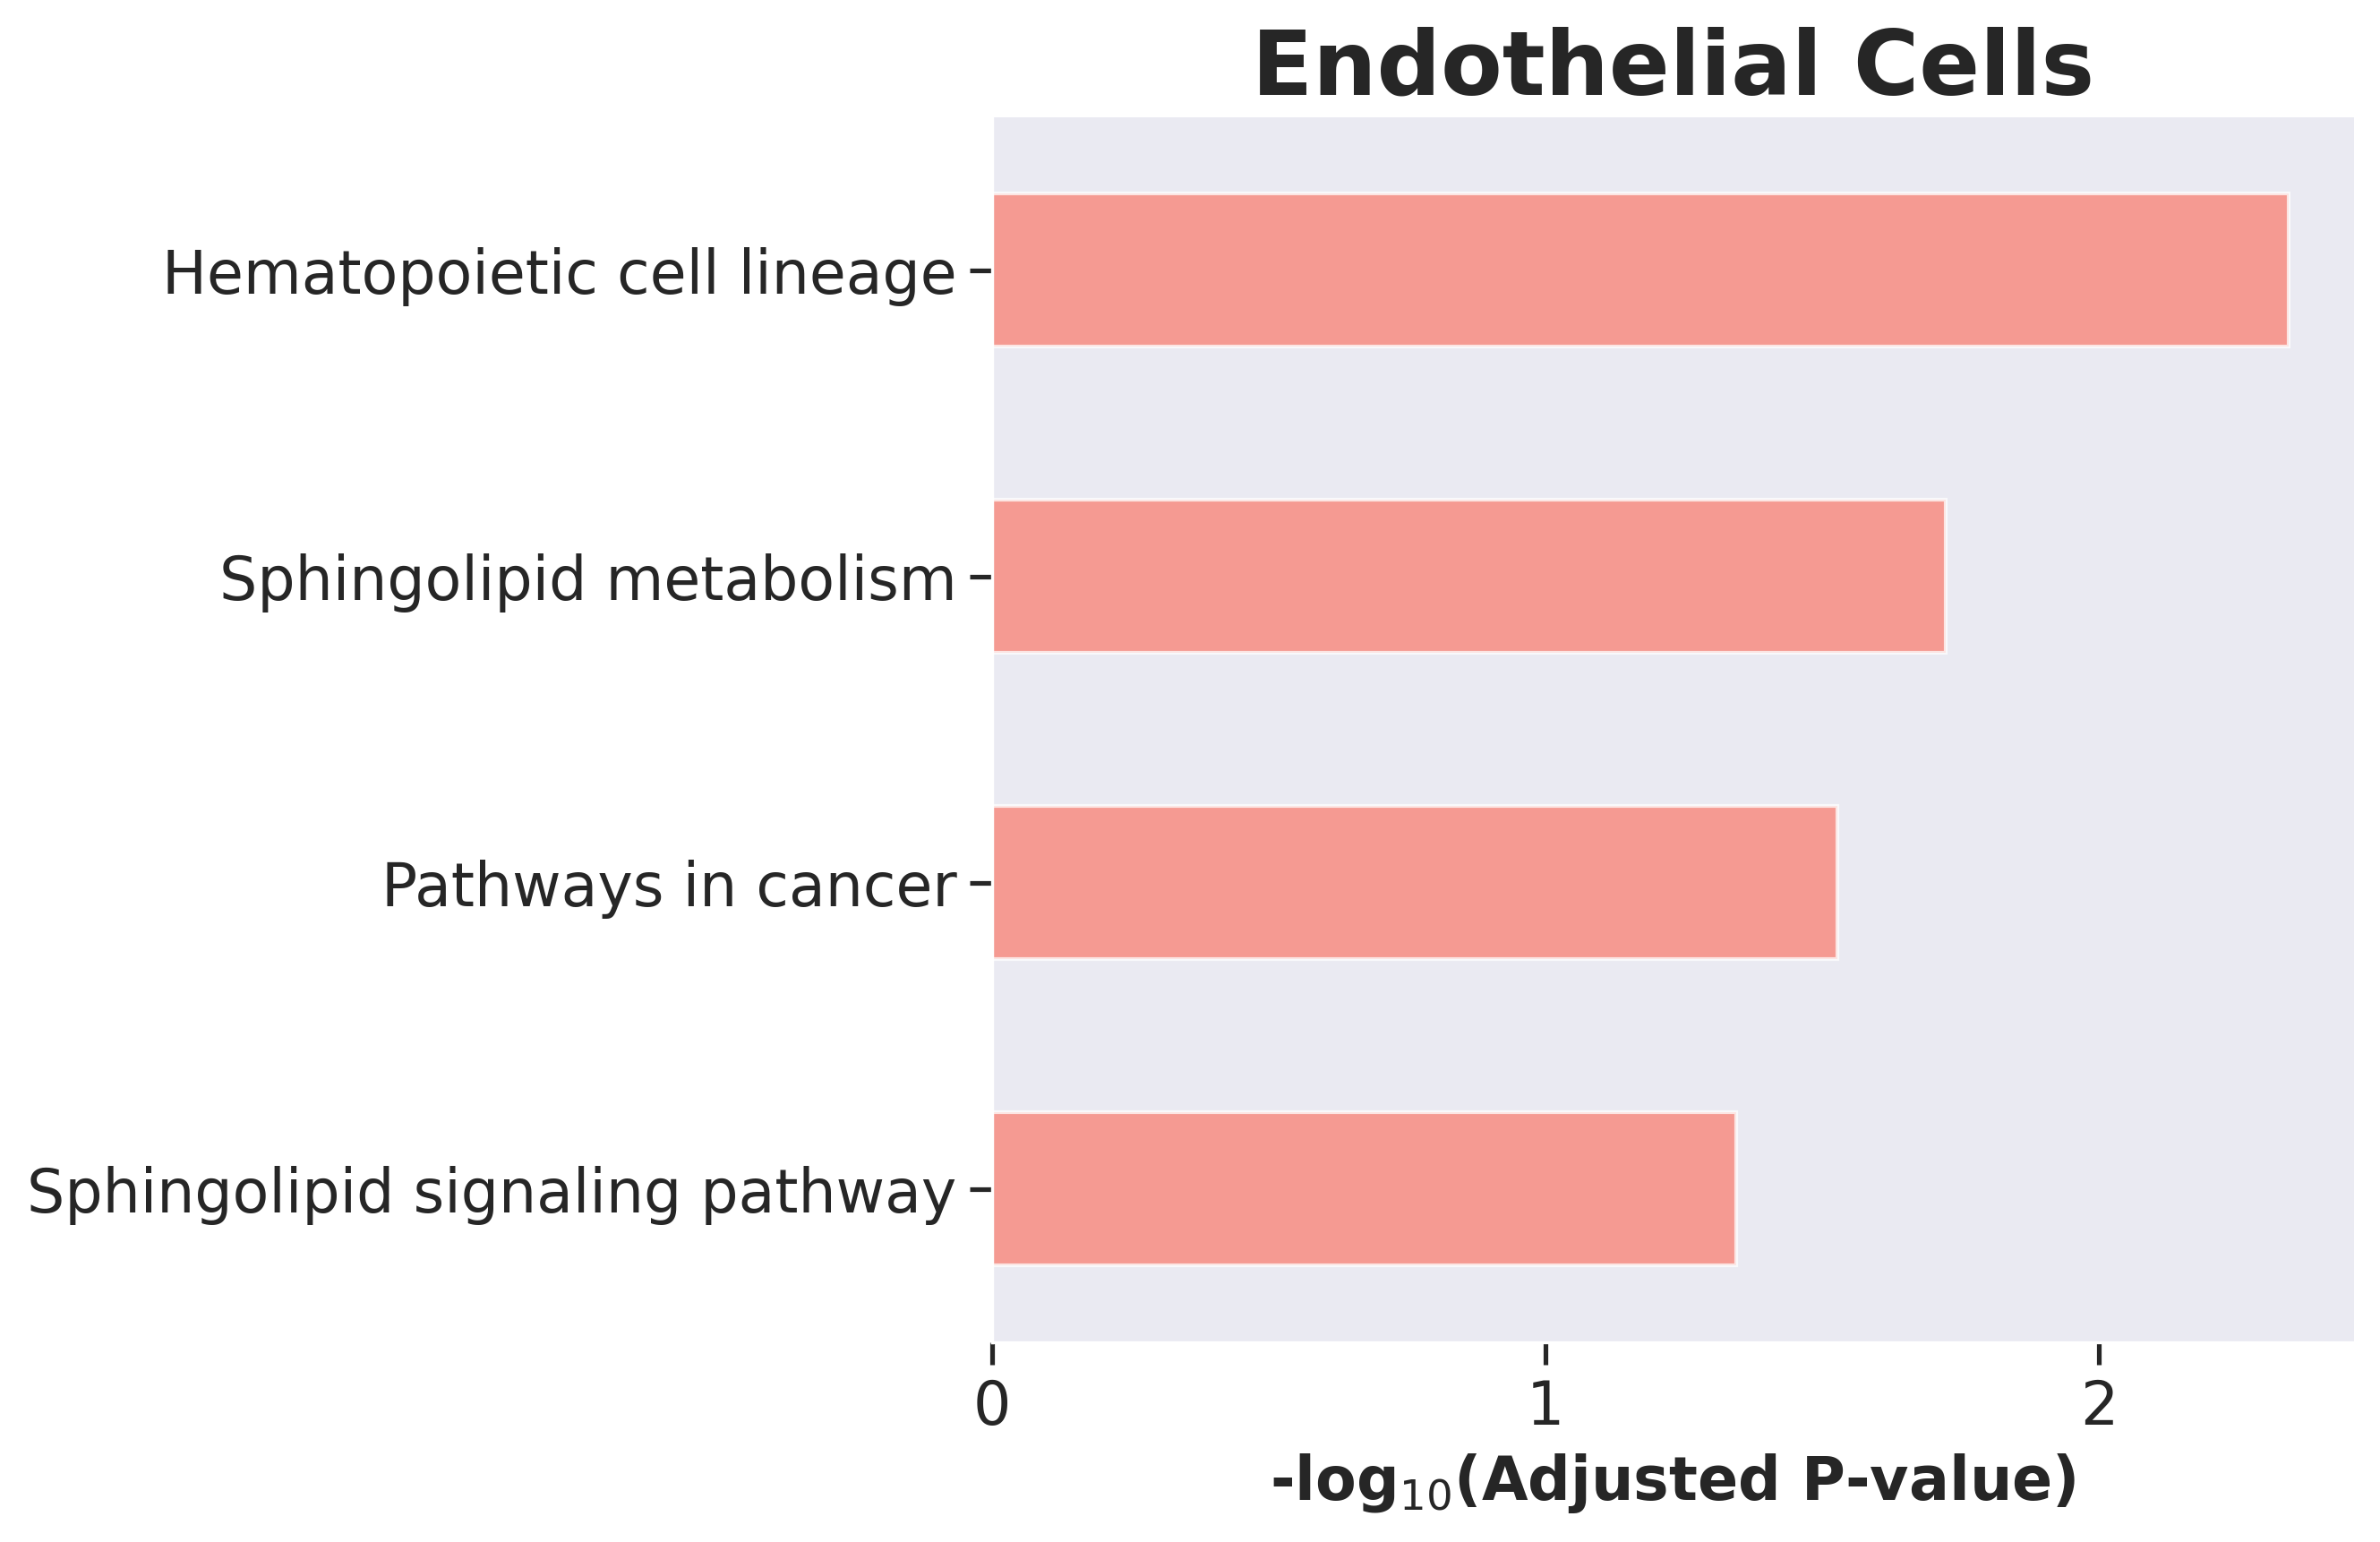

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, cop

Hepatocytes - central
['Fmo3' 'Nrg1' 'Cyp1a2' 'Cyp1a1' 'Nfe2l2' 'Airn' 'Ugdh' 'Them7' 'Ahrr'
 'Tiparp']


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


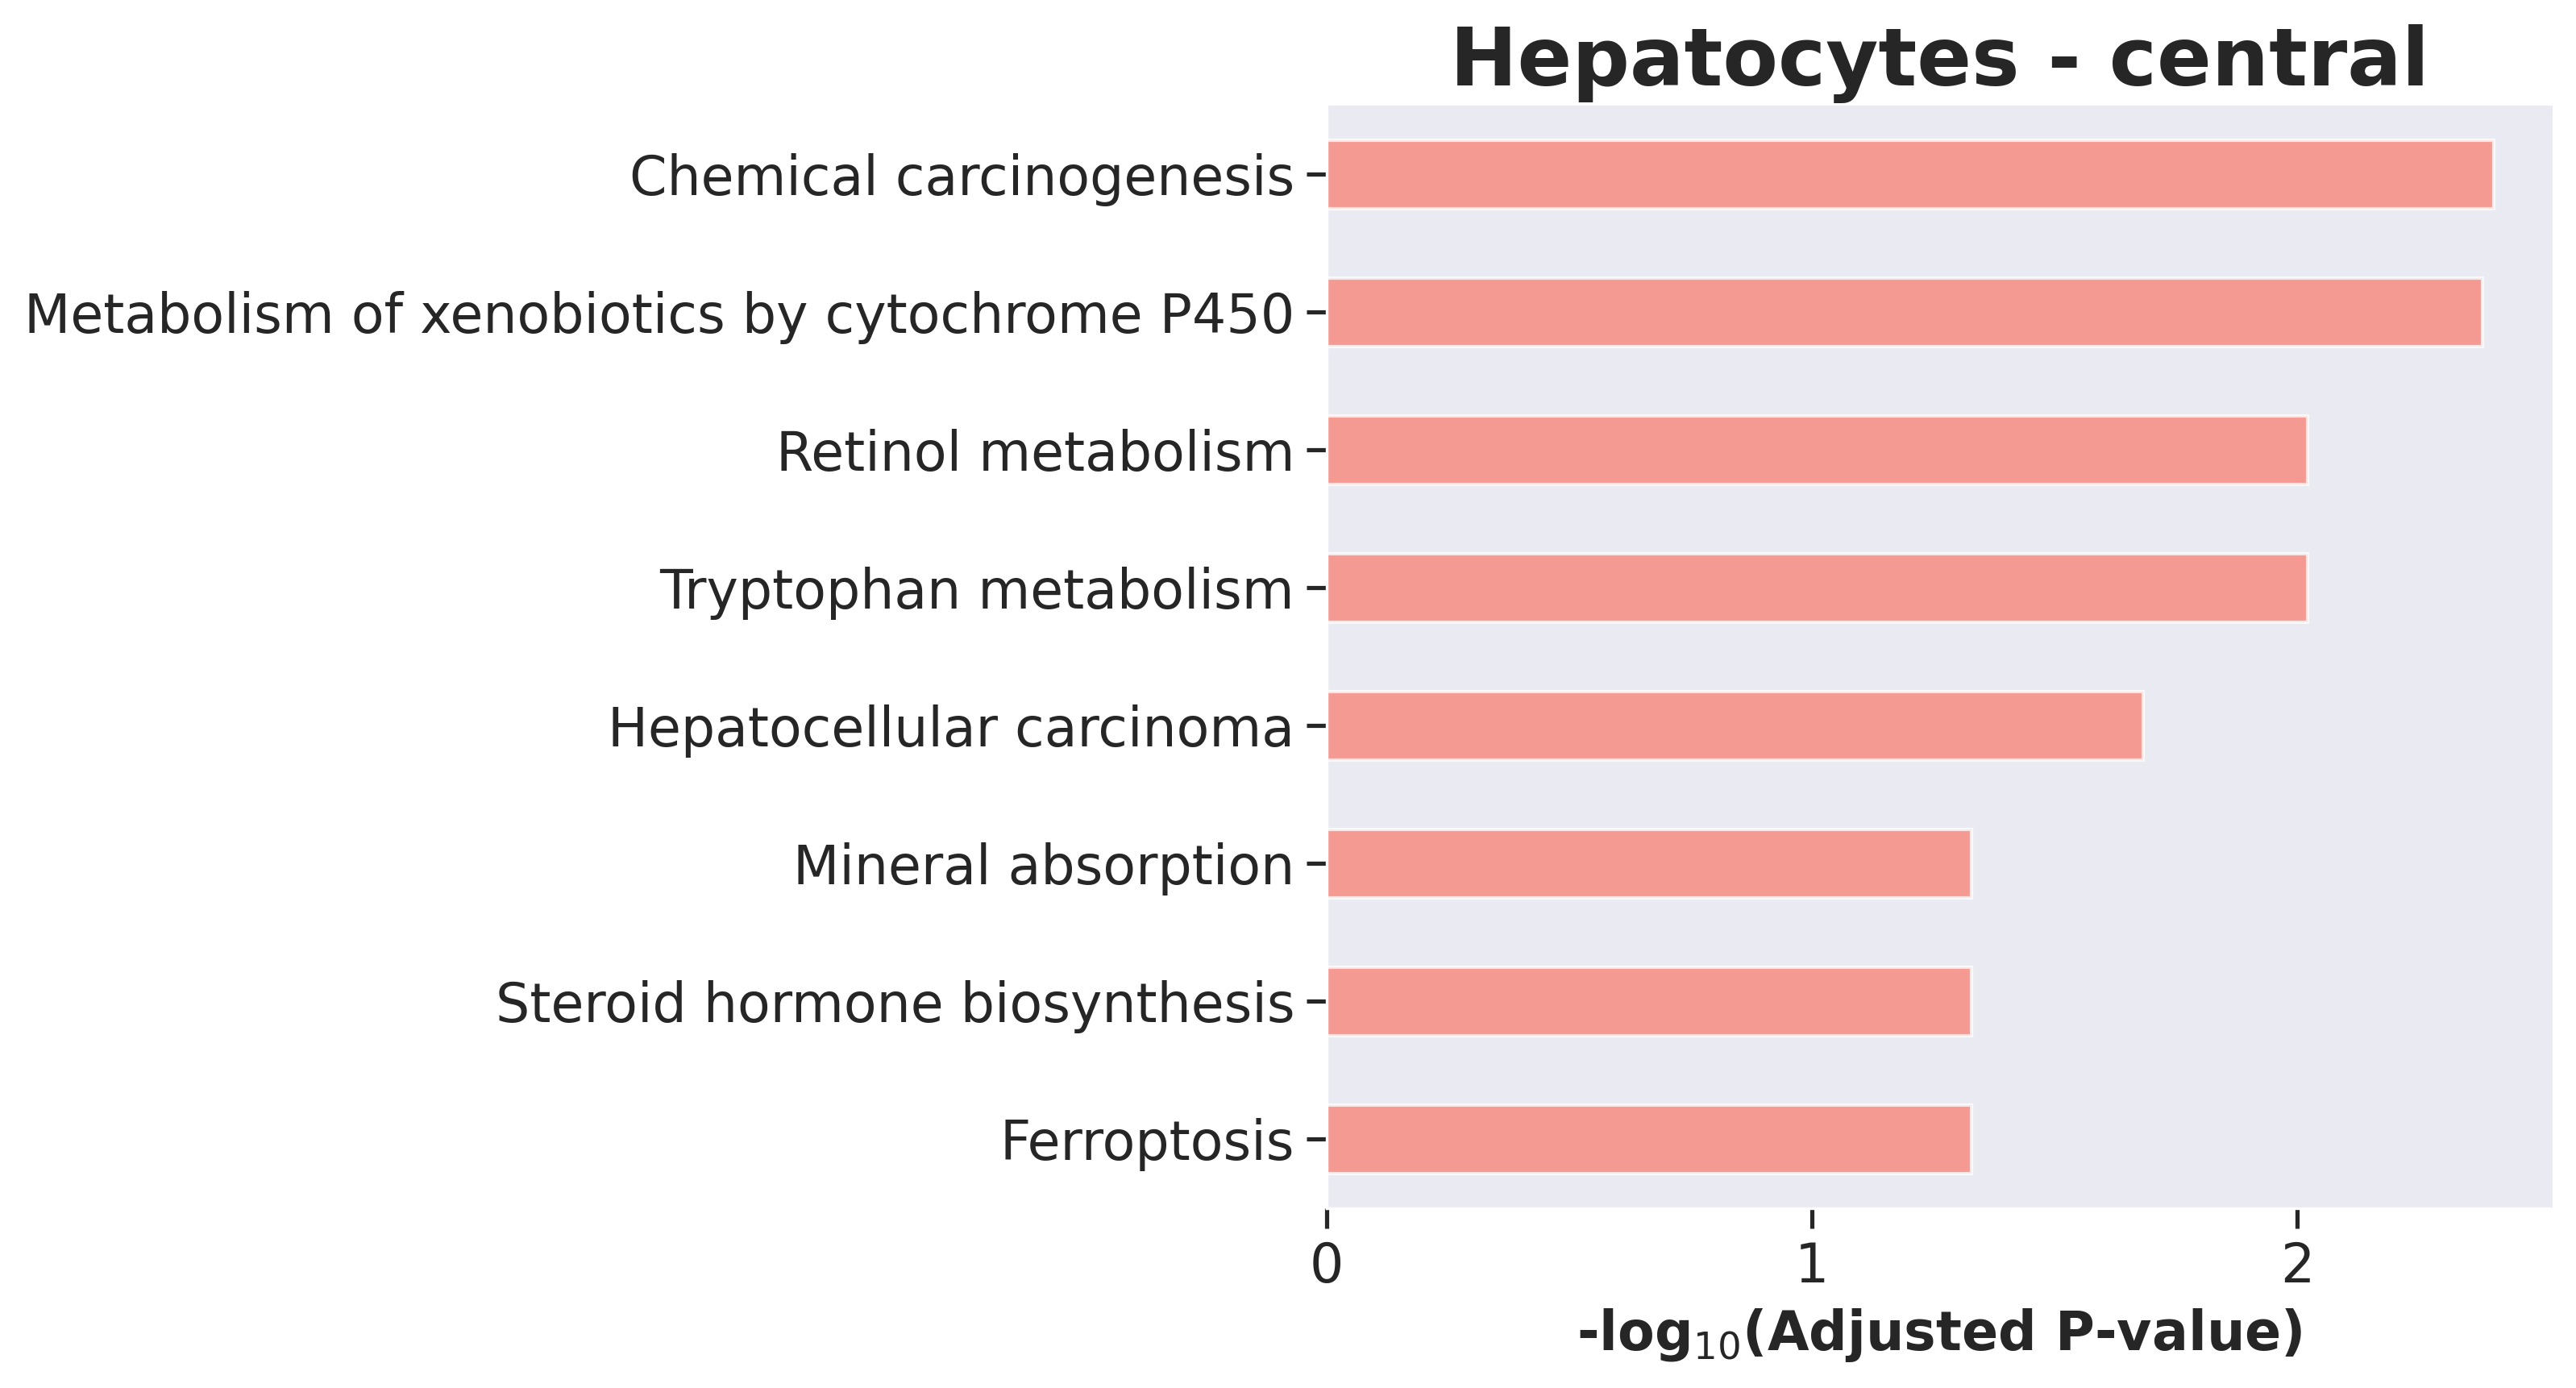

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.


Hepatocytes - portal


... storing 'celltype' as categorical
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
... storing 'dose' as categorical


['Fmo3' 'Airn' 'Cyp1a2' 'Cyp1a1' 'Nrg1' 'Esrrg' 'Reln' 'Tiparp' 'Ugdh'
 'Pvt1']


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


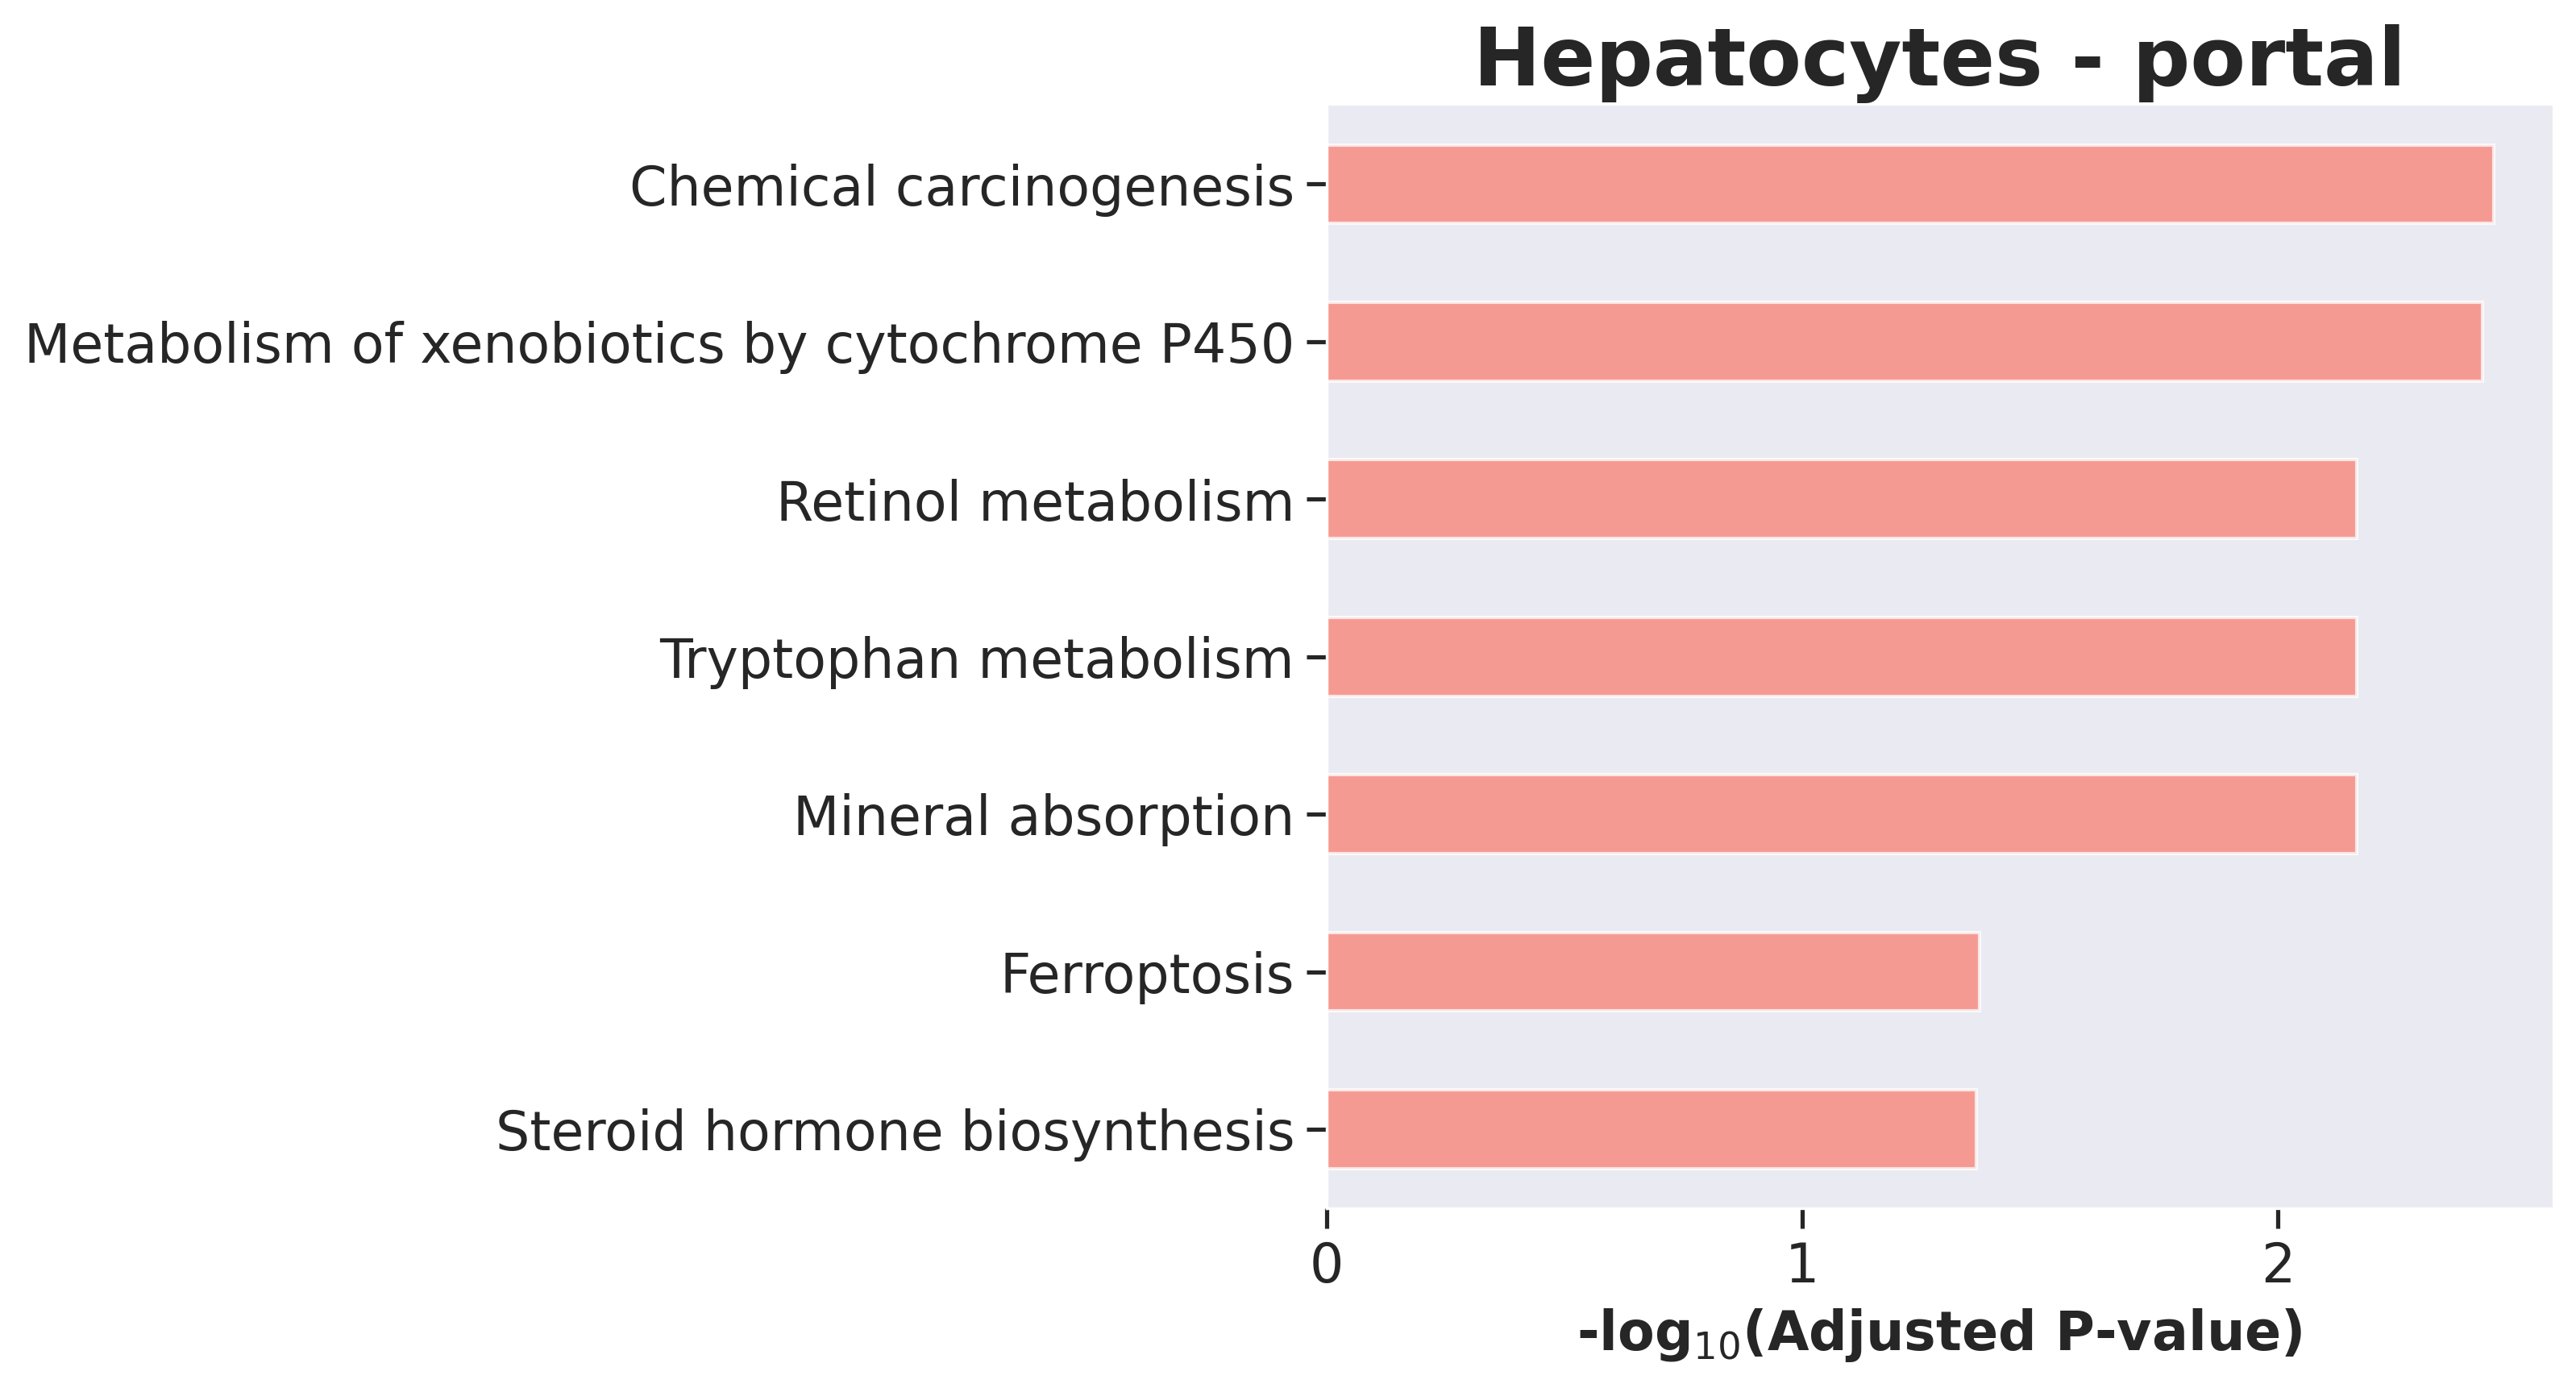

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, cop

Portal Fibroblasts
['Nrg1' 'Pcnx2' 'Pak3' 'Myof' 'Tiparp' 'Fmo3' 'Bicd1' 'Airn' 'Ptgs1'
 'Abi1']


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


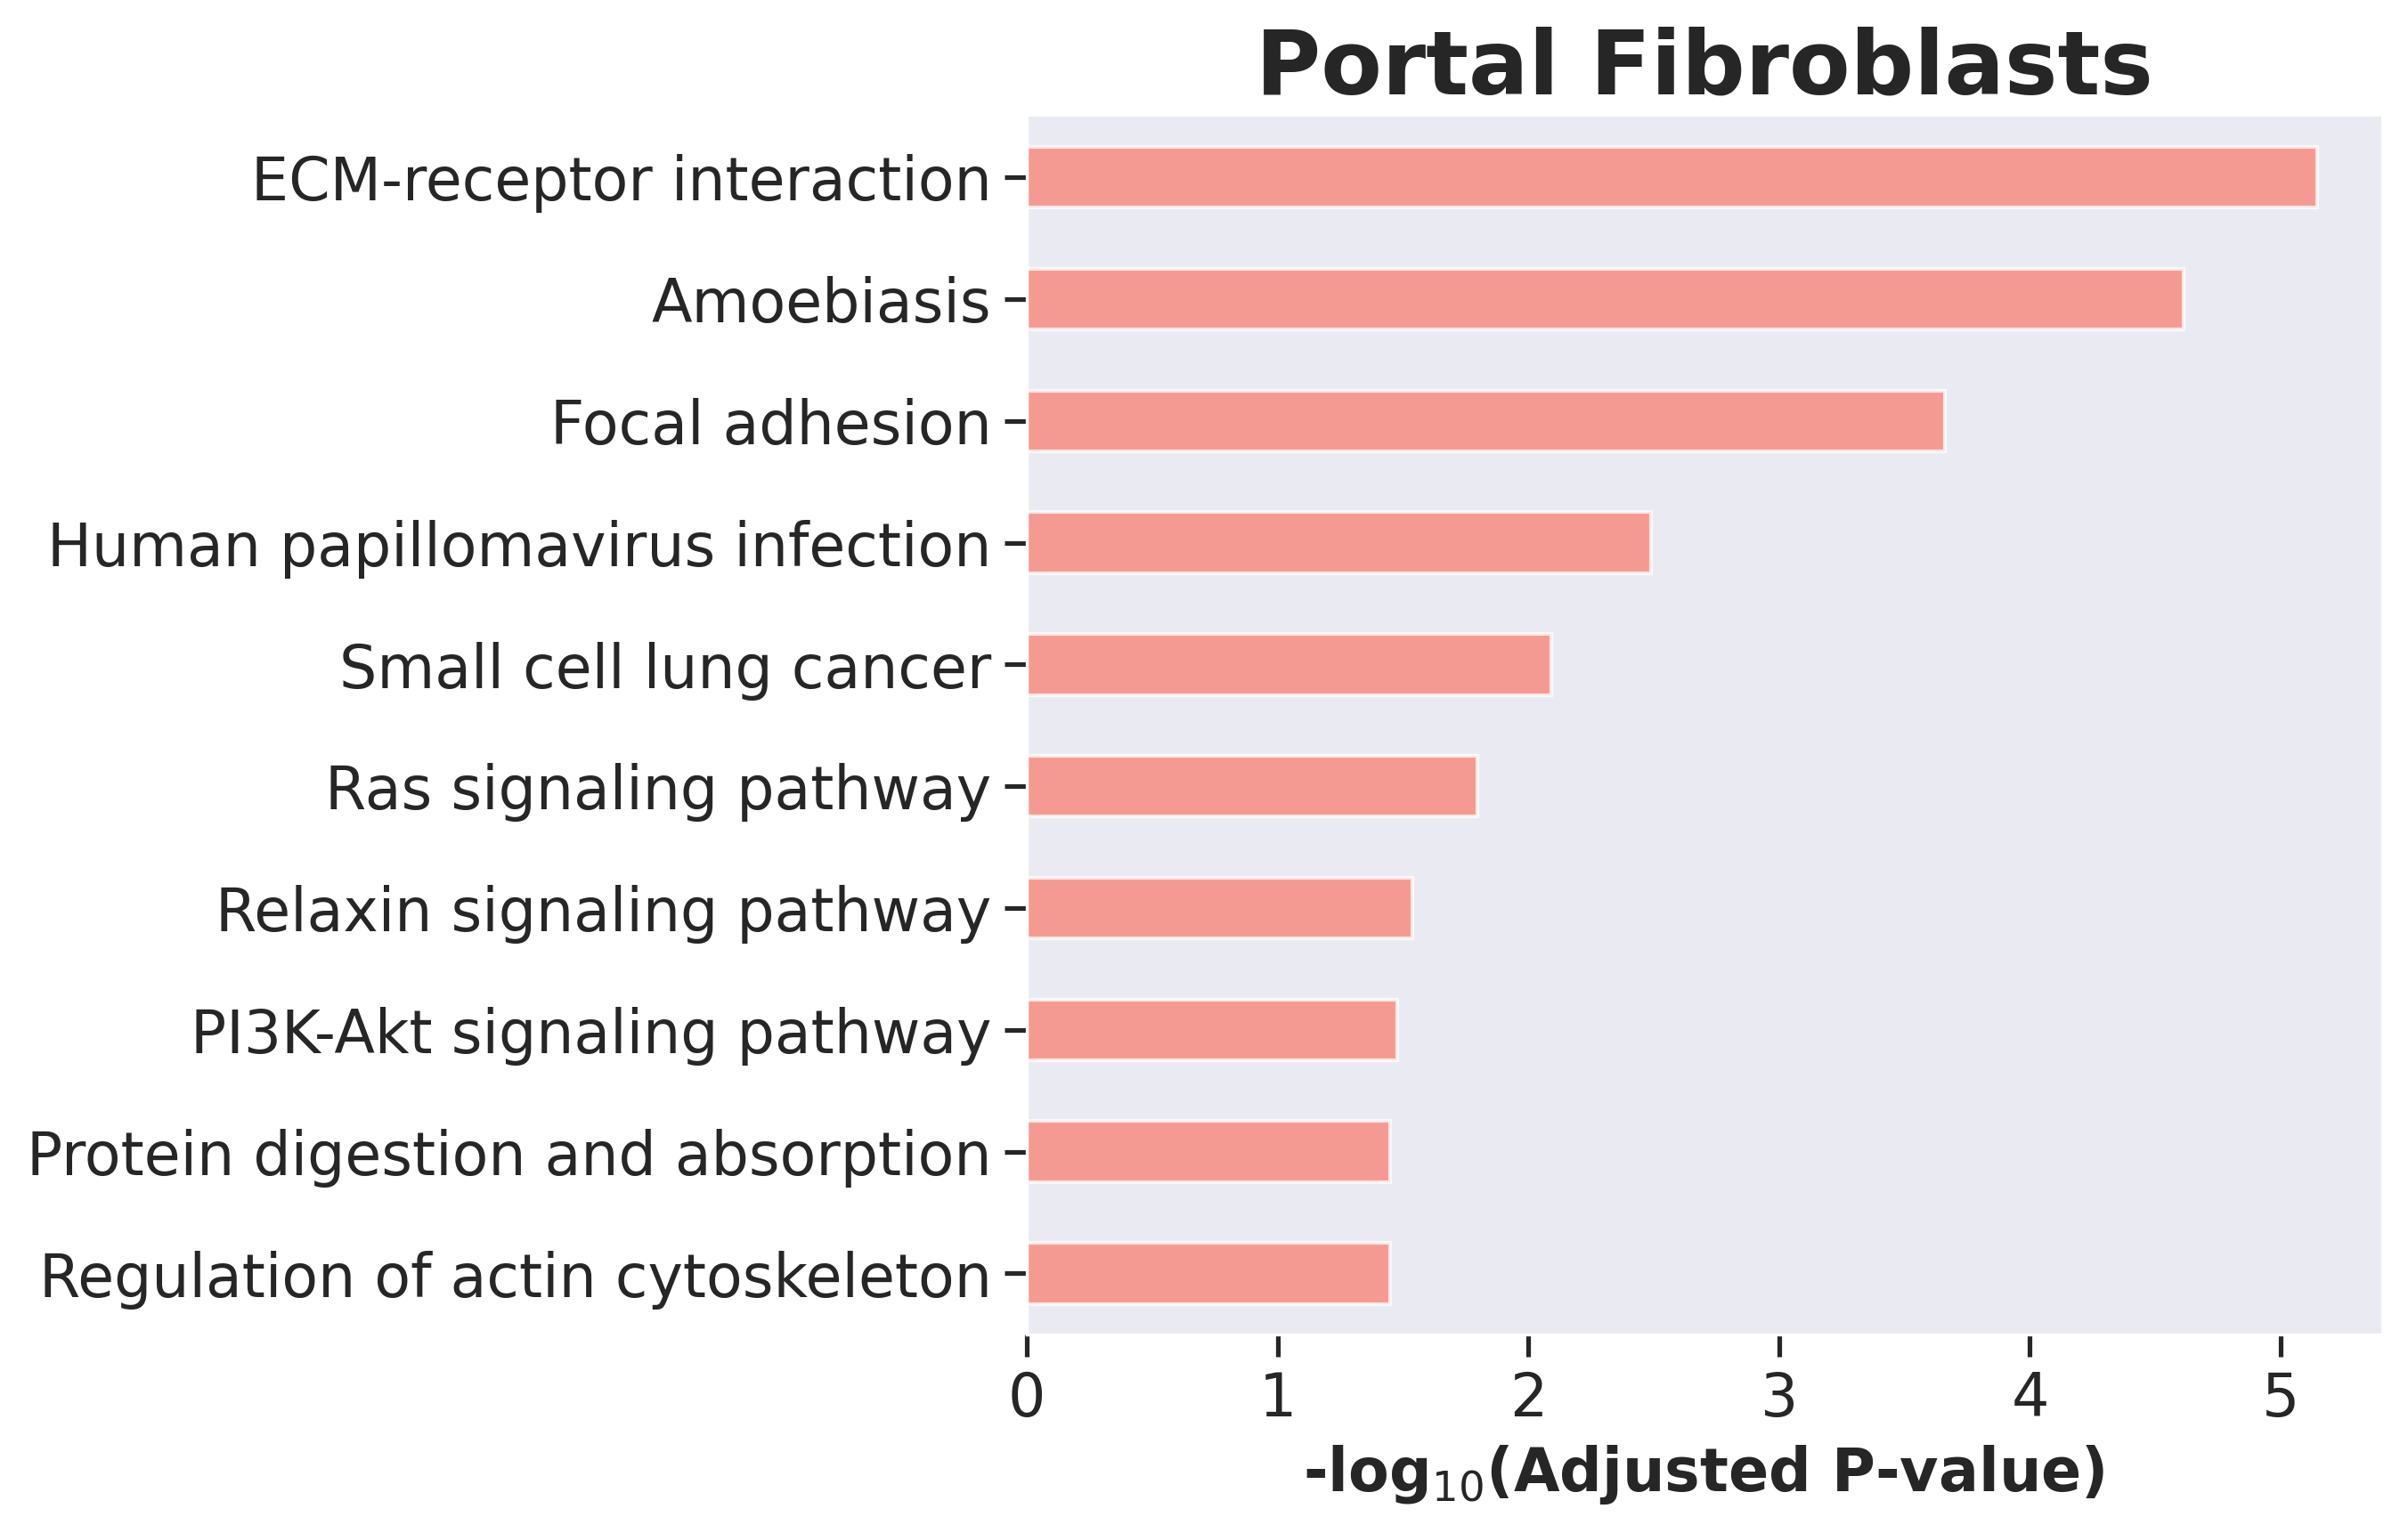

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, cop

Stellate Cells
['Spon1' 'Tnc' 'Cacna1c' 'Myof' 'Abi1' 'Rapgef5' 'Tpm1' 'Bco1' 'Pcdh7'
 'Rgs6']


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


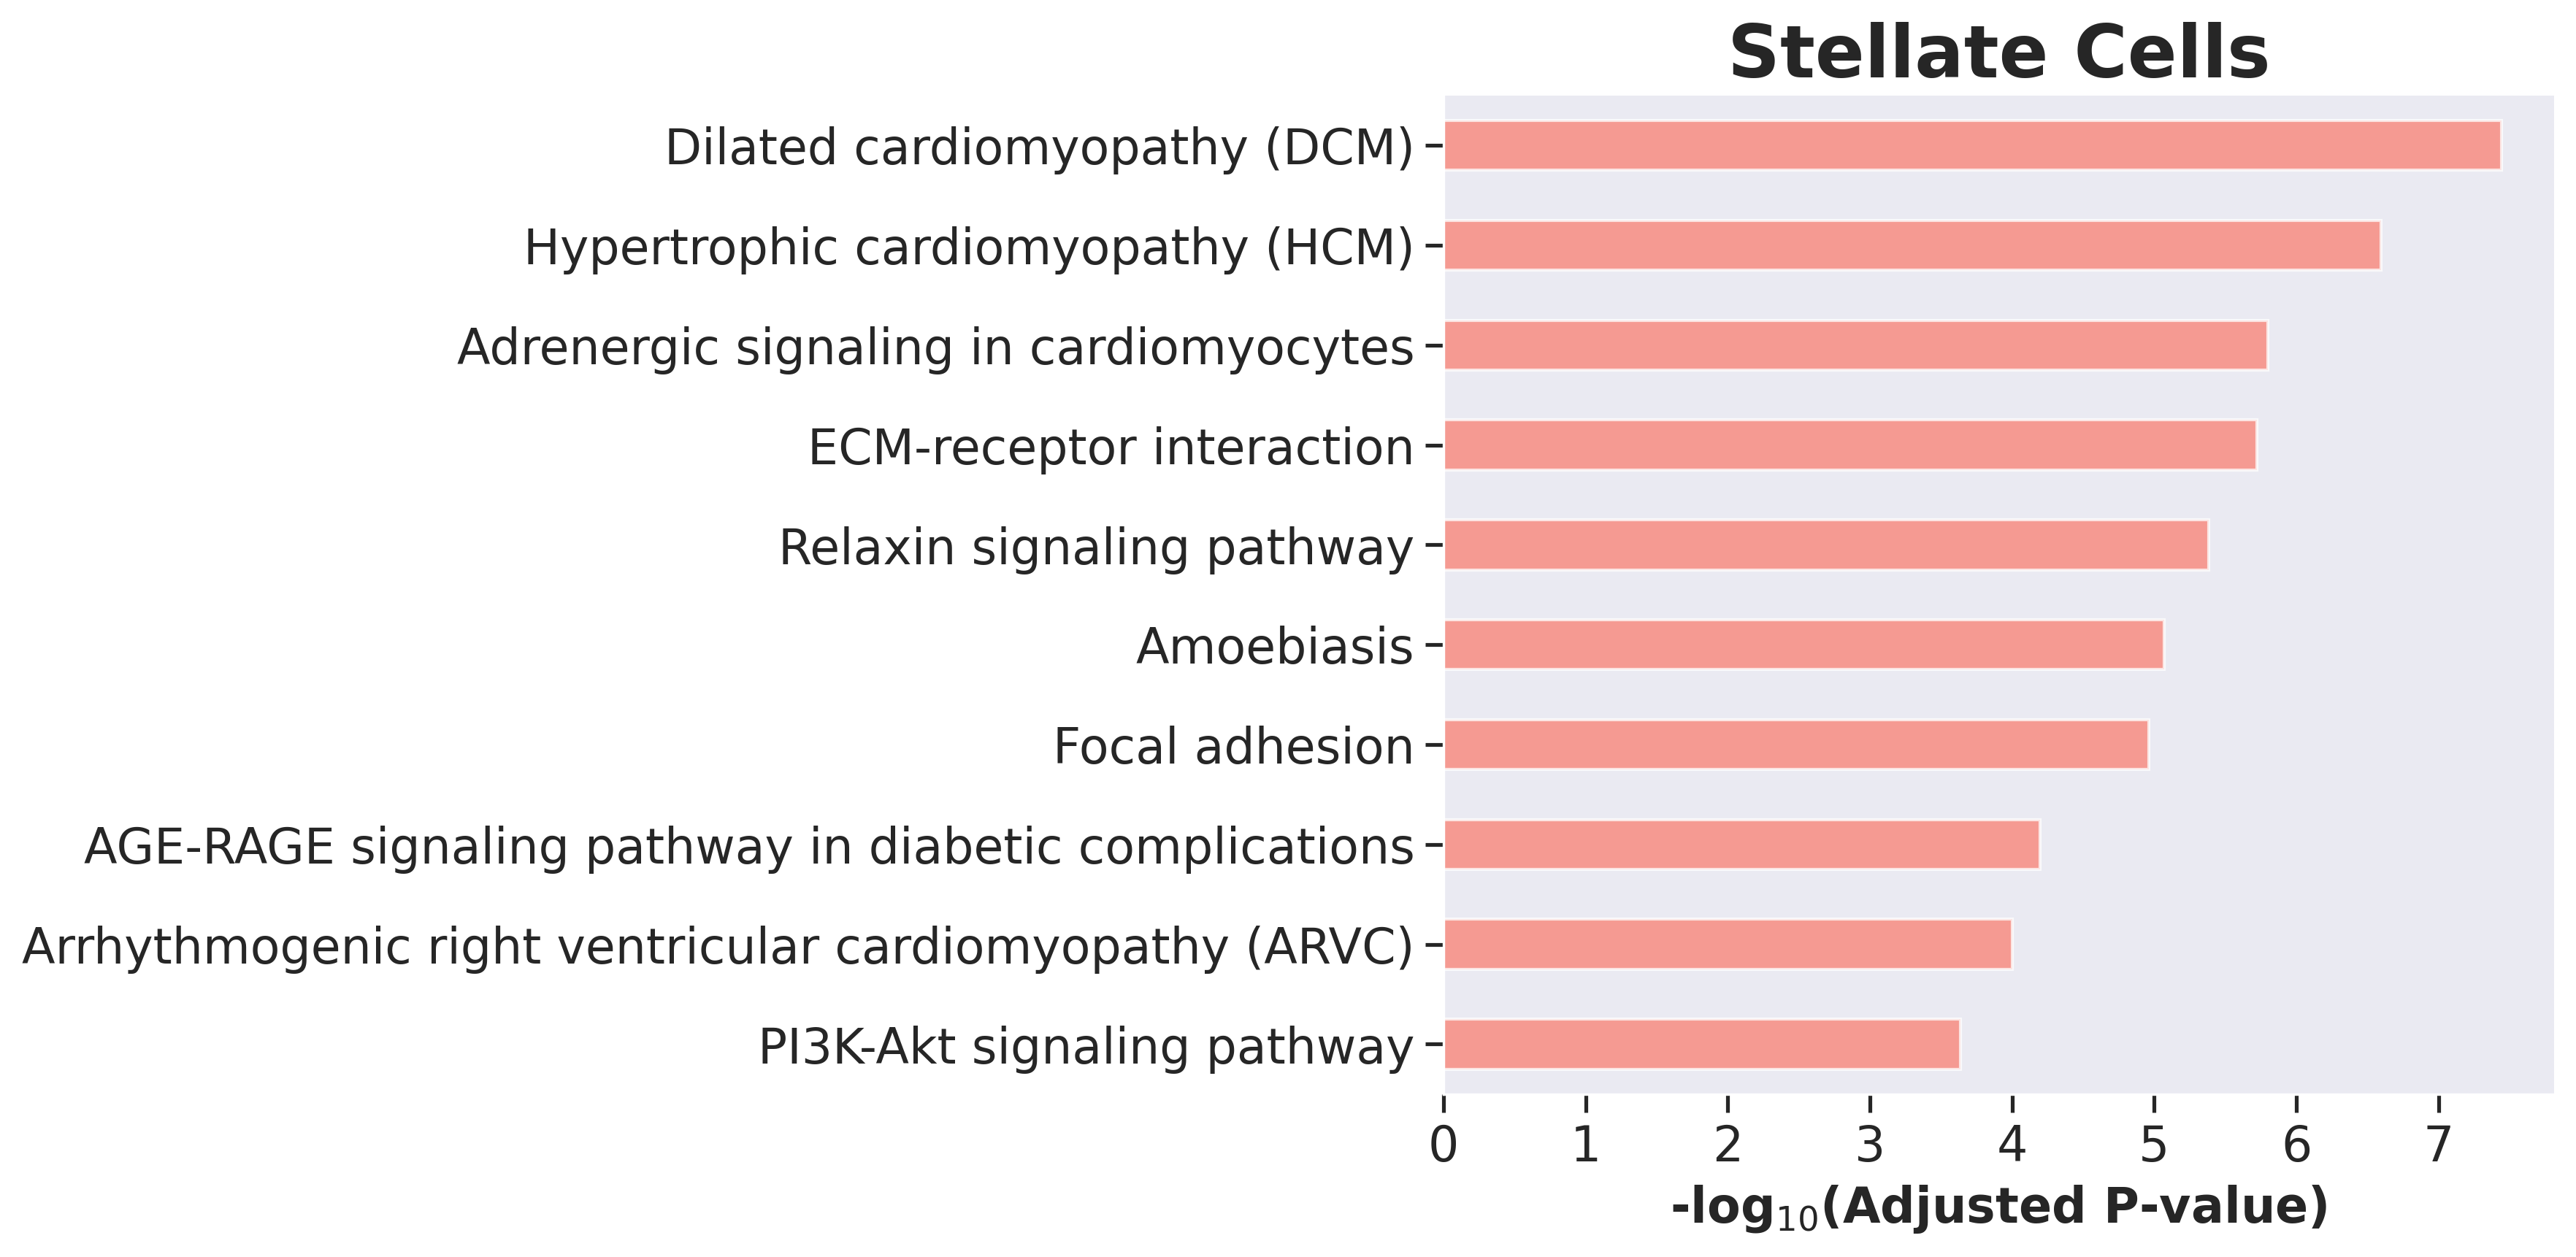

In [36]:
for cell in celltypes:
    print(cell)
    
    CD4T = adata[adata.obs["celltype"] ==cell]
    sc.tl.rank_genes_groups(CD4T, groupby="dose", method="wilcoxon")
    diff_genes = CD4T.uns["rank_genes_groups"]["names"]["30"]
    glist = diff_genes[:125]
    print(glist[:10])
    glist = glist.tolist()
    enr = gp.enrichr(gene_list=glist,
                     gene_sets=["KEGG_2019_Mouse"],
                     organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                     description='test_name',
                     outdir='test/enrichr_kegg',
                     # no_plot=True,
                     cutoff=0.5 # test dataset, use lower value from range(0,1)
                    )
    gp.plot.barplot(enr.res2d, title = f"{cell}")
    plt.show()

In [6]:
CD4T = adata[adata.obs["dose"] == "30"]

In [8]:
sc.tl.rank_genes_groups(CD4T, groupby="celltype", method="wilcoxon", )

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, cop

In [9]:
diff_genes = CD4T.uns["rank_genes_groups"]["names"]

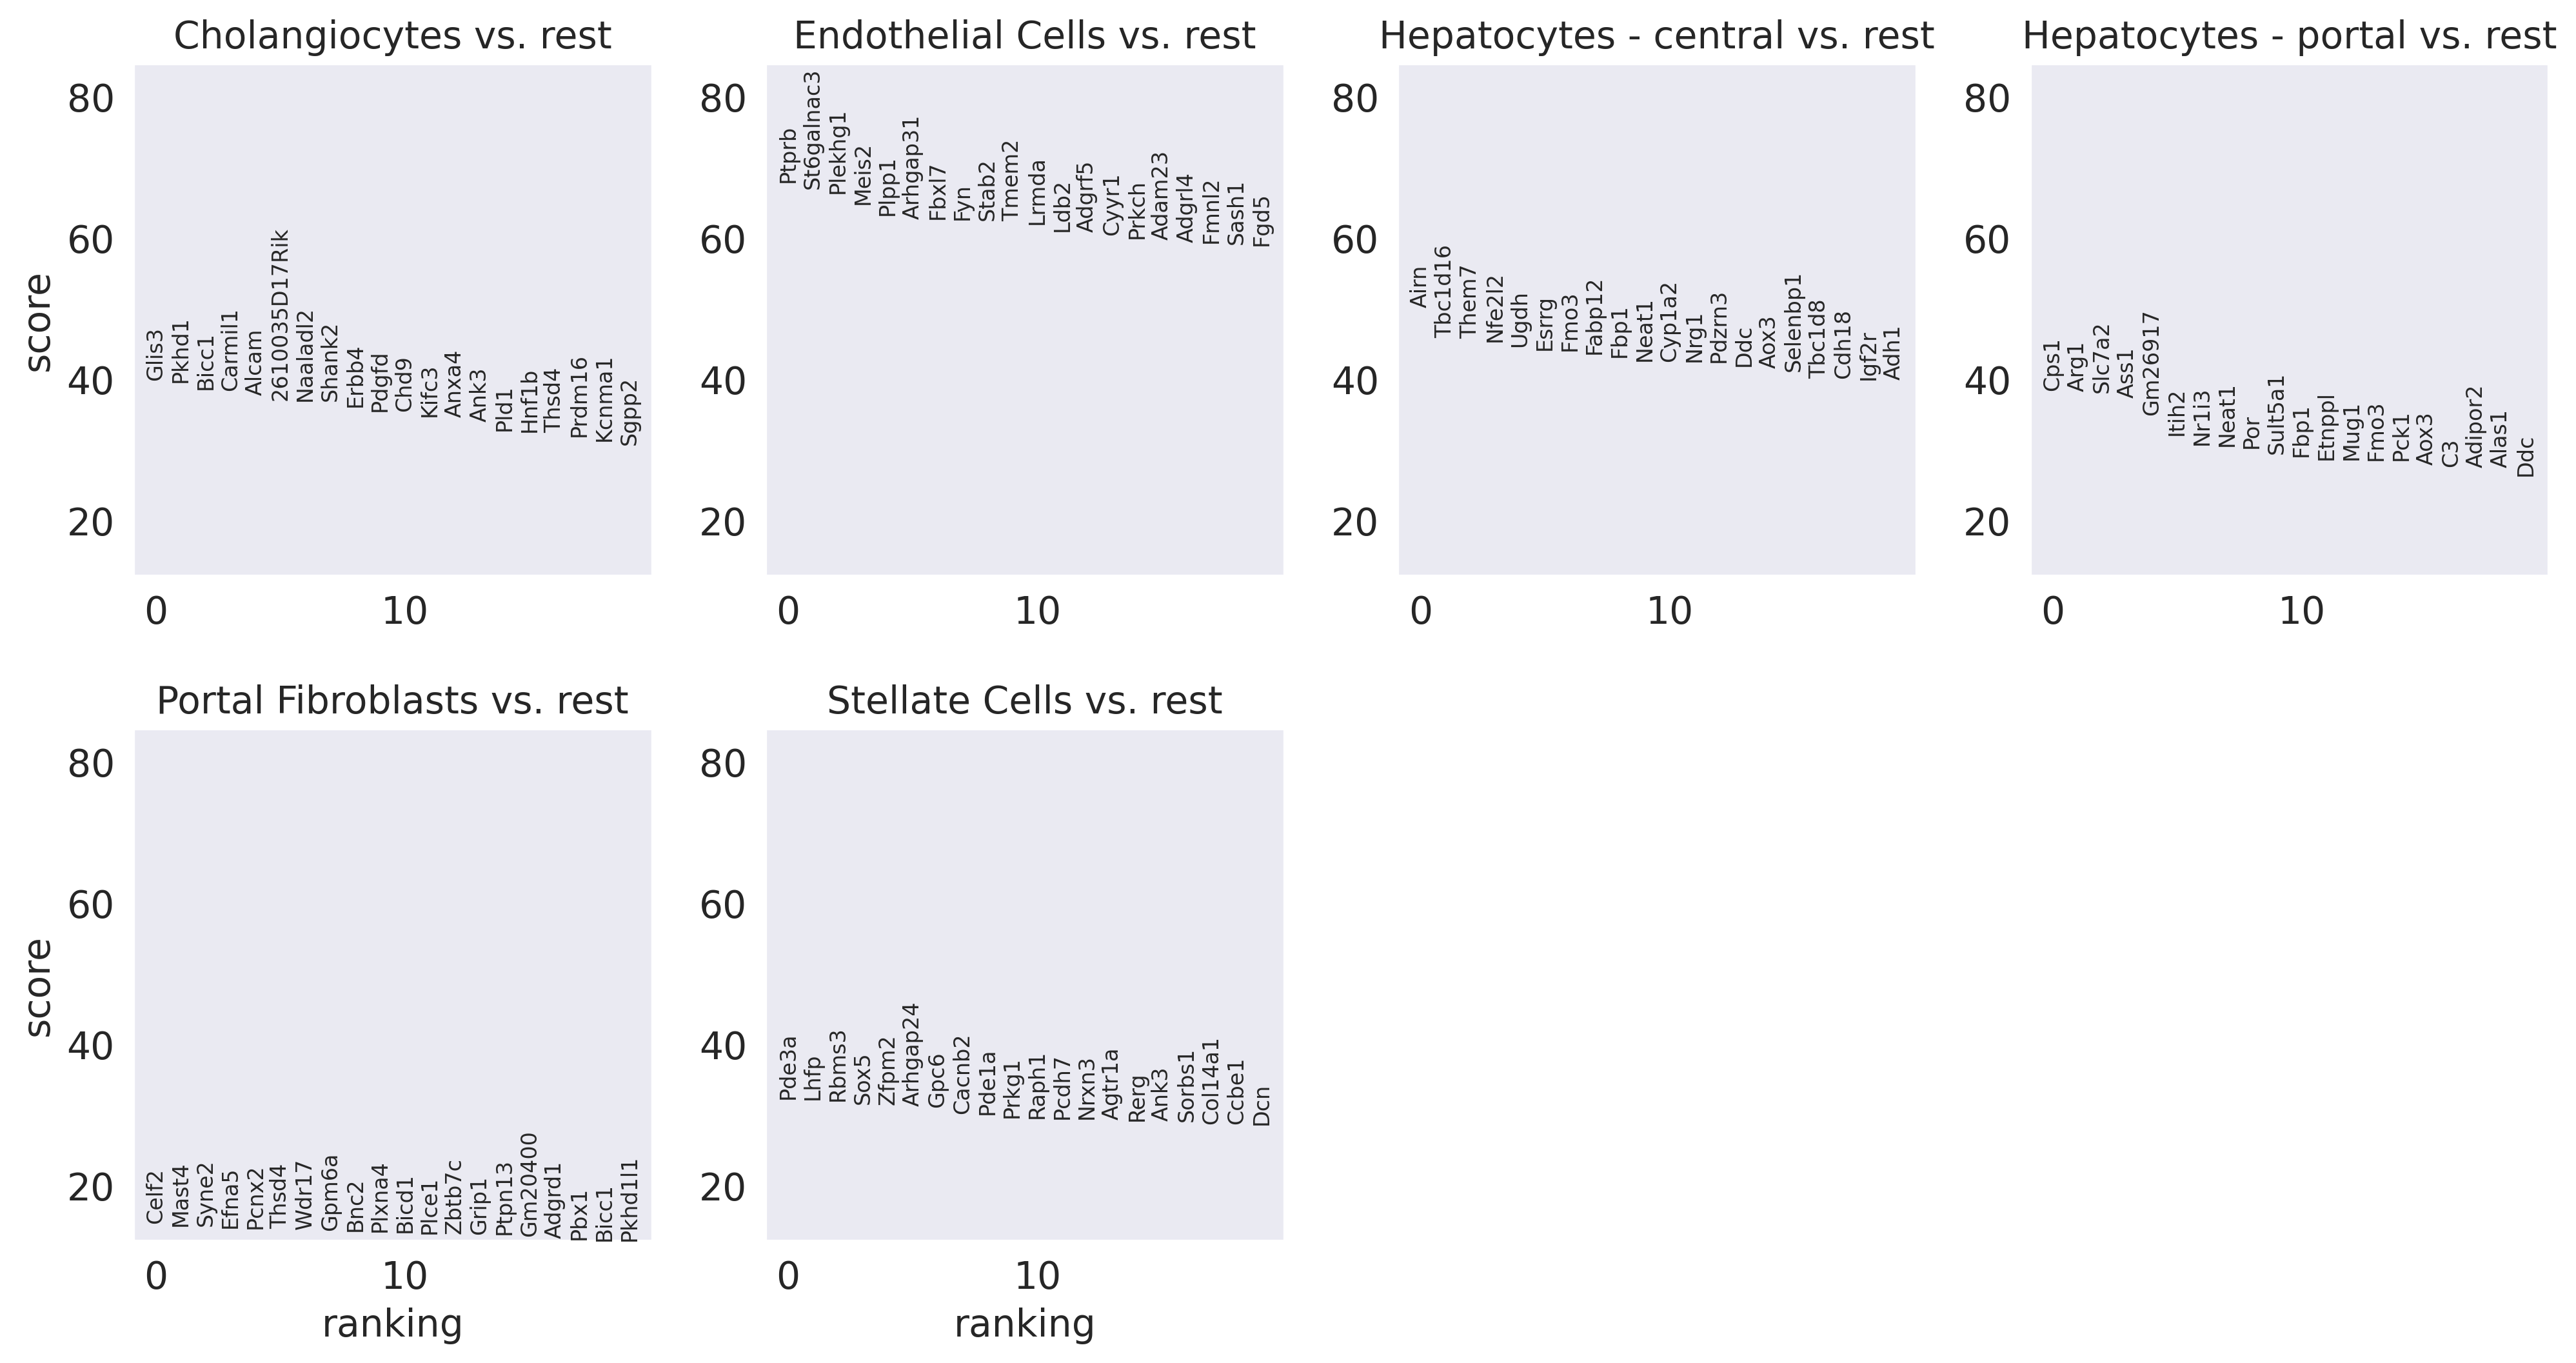

In [11]:
sc.pl.rank_genes_groups(CD4T)

['Airn' 'Tbc1d16' 'Them7' 'Nfe2l2' 'Ugdh' 'Esrrg' 'Fmo3' 'Fabp12' 'Fbp1'
 'Neat1']


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


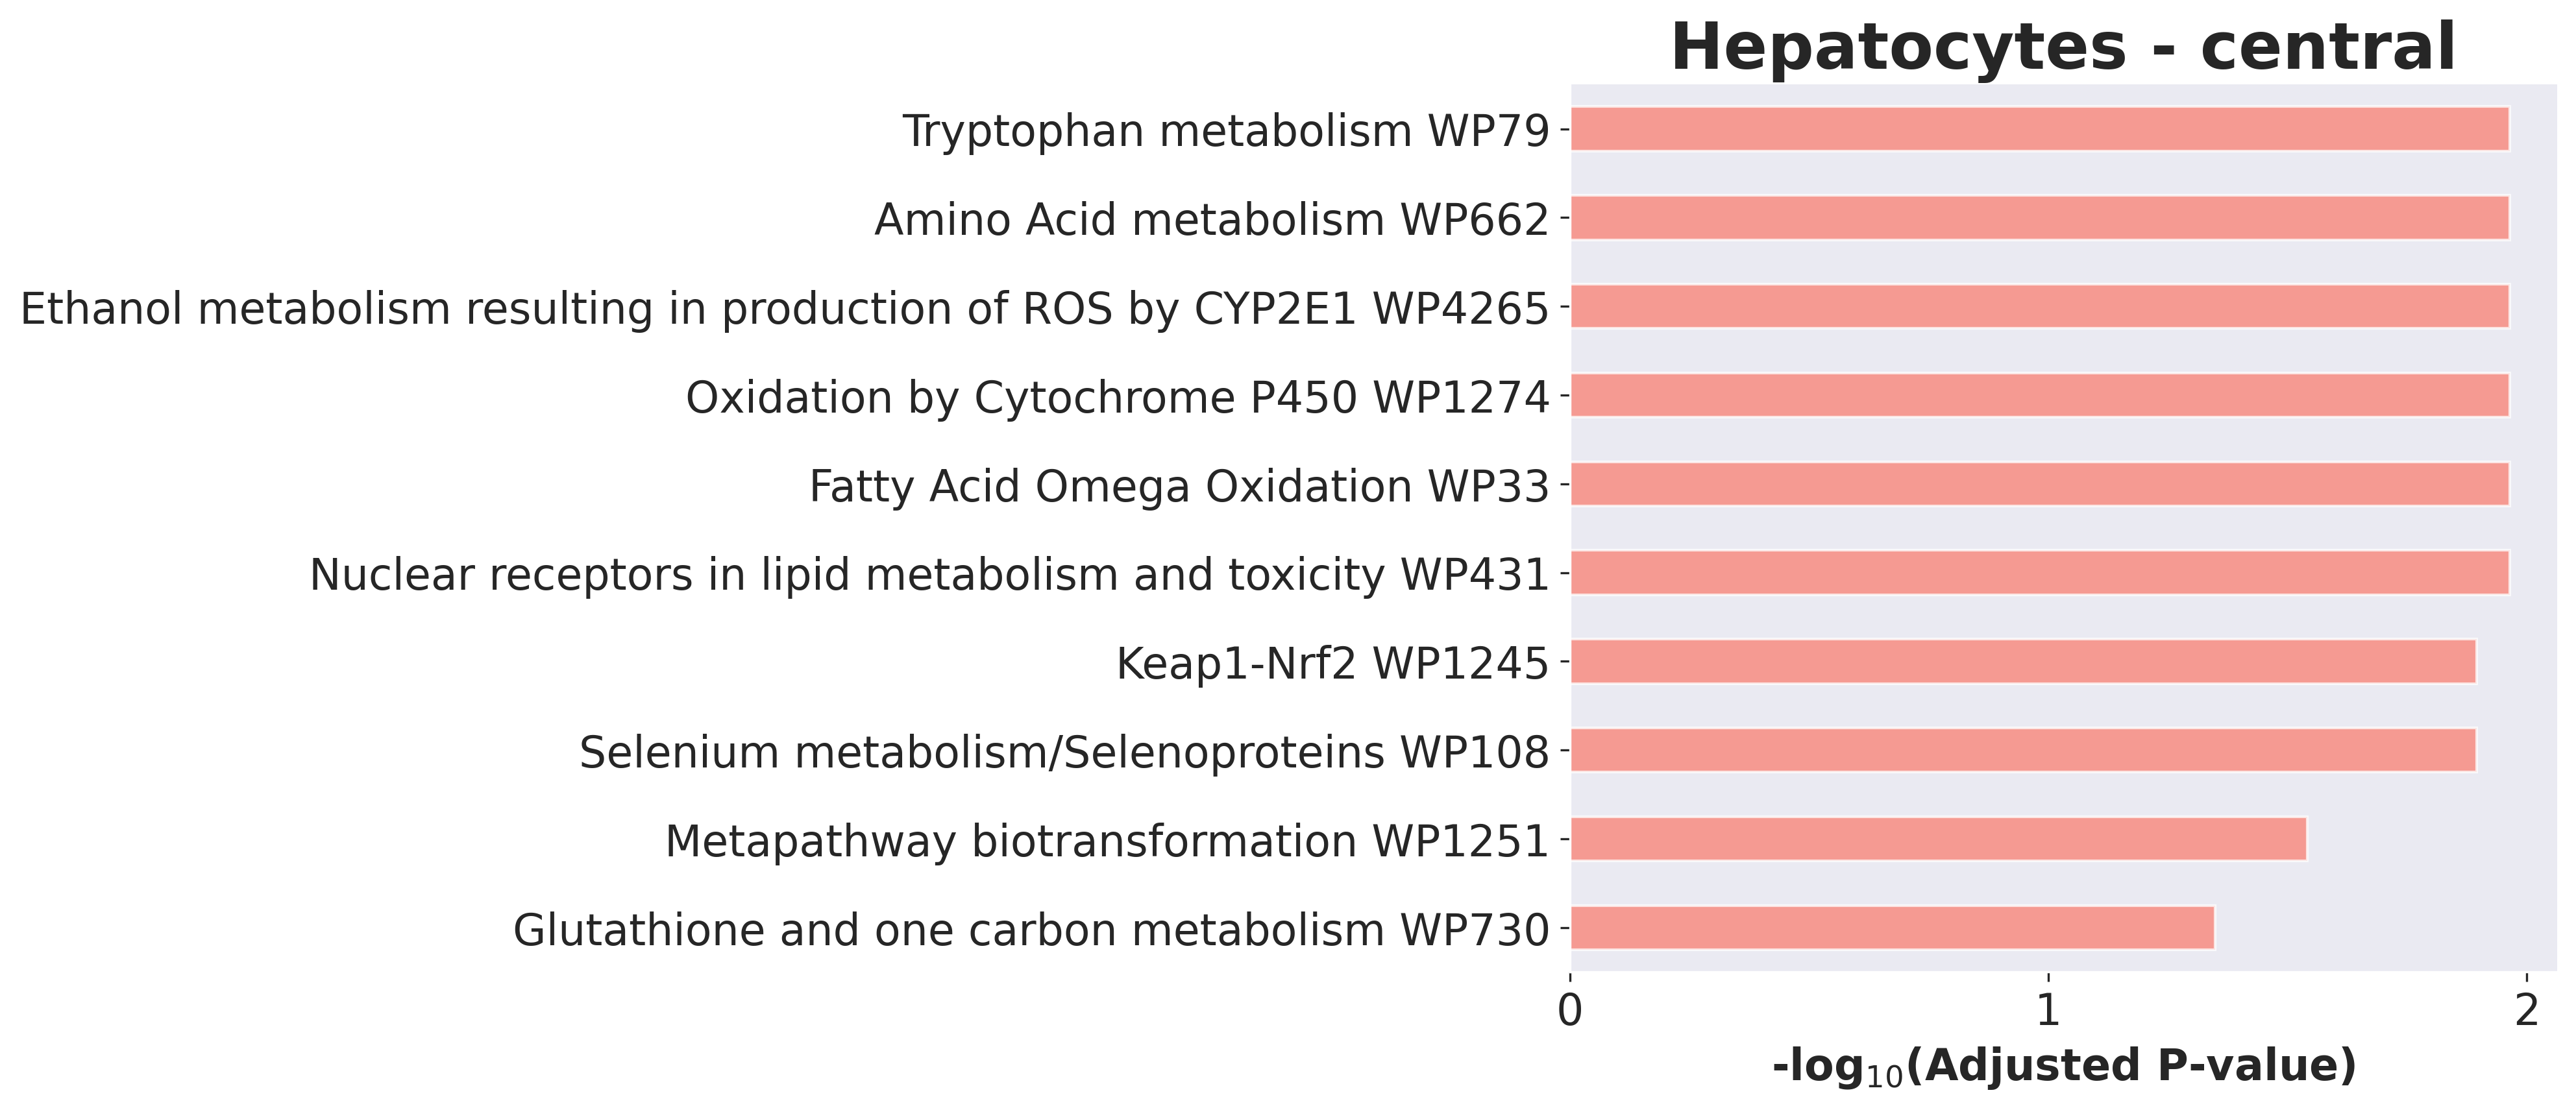

['Cps1' 'Arg1' 'Slc7a2' 'Ass1' 'Gm26917' 'Itih2' 'Nr1i3' 'Neat1' 'Por'
 'Sult5a1']


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


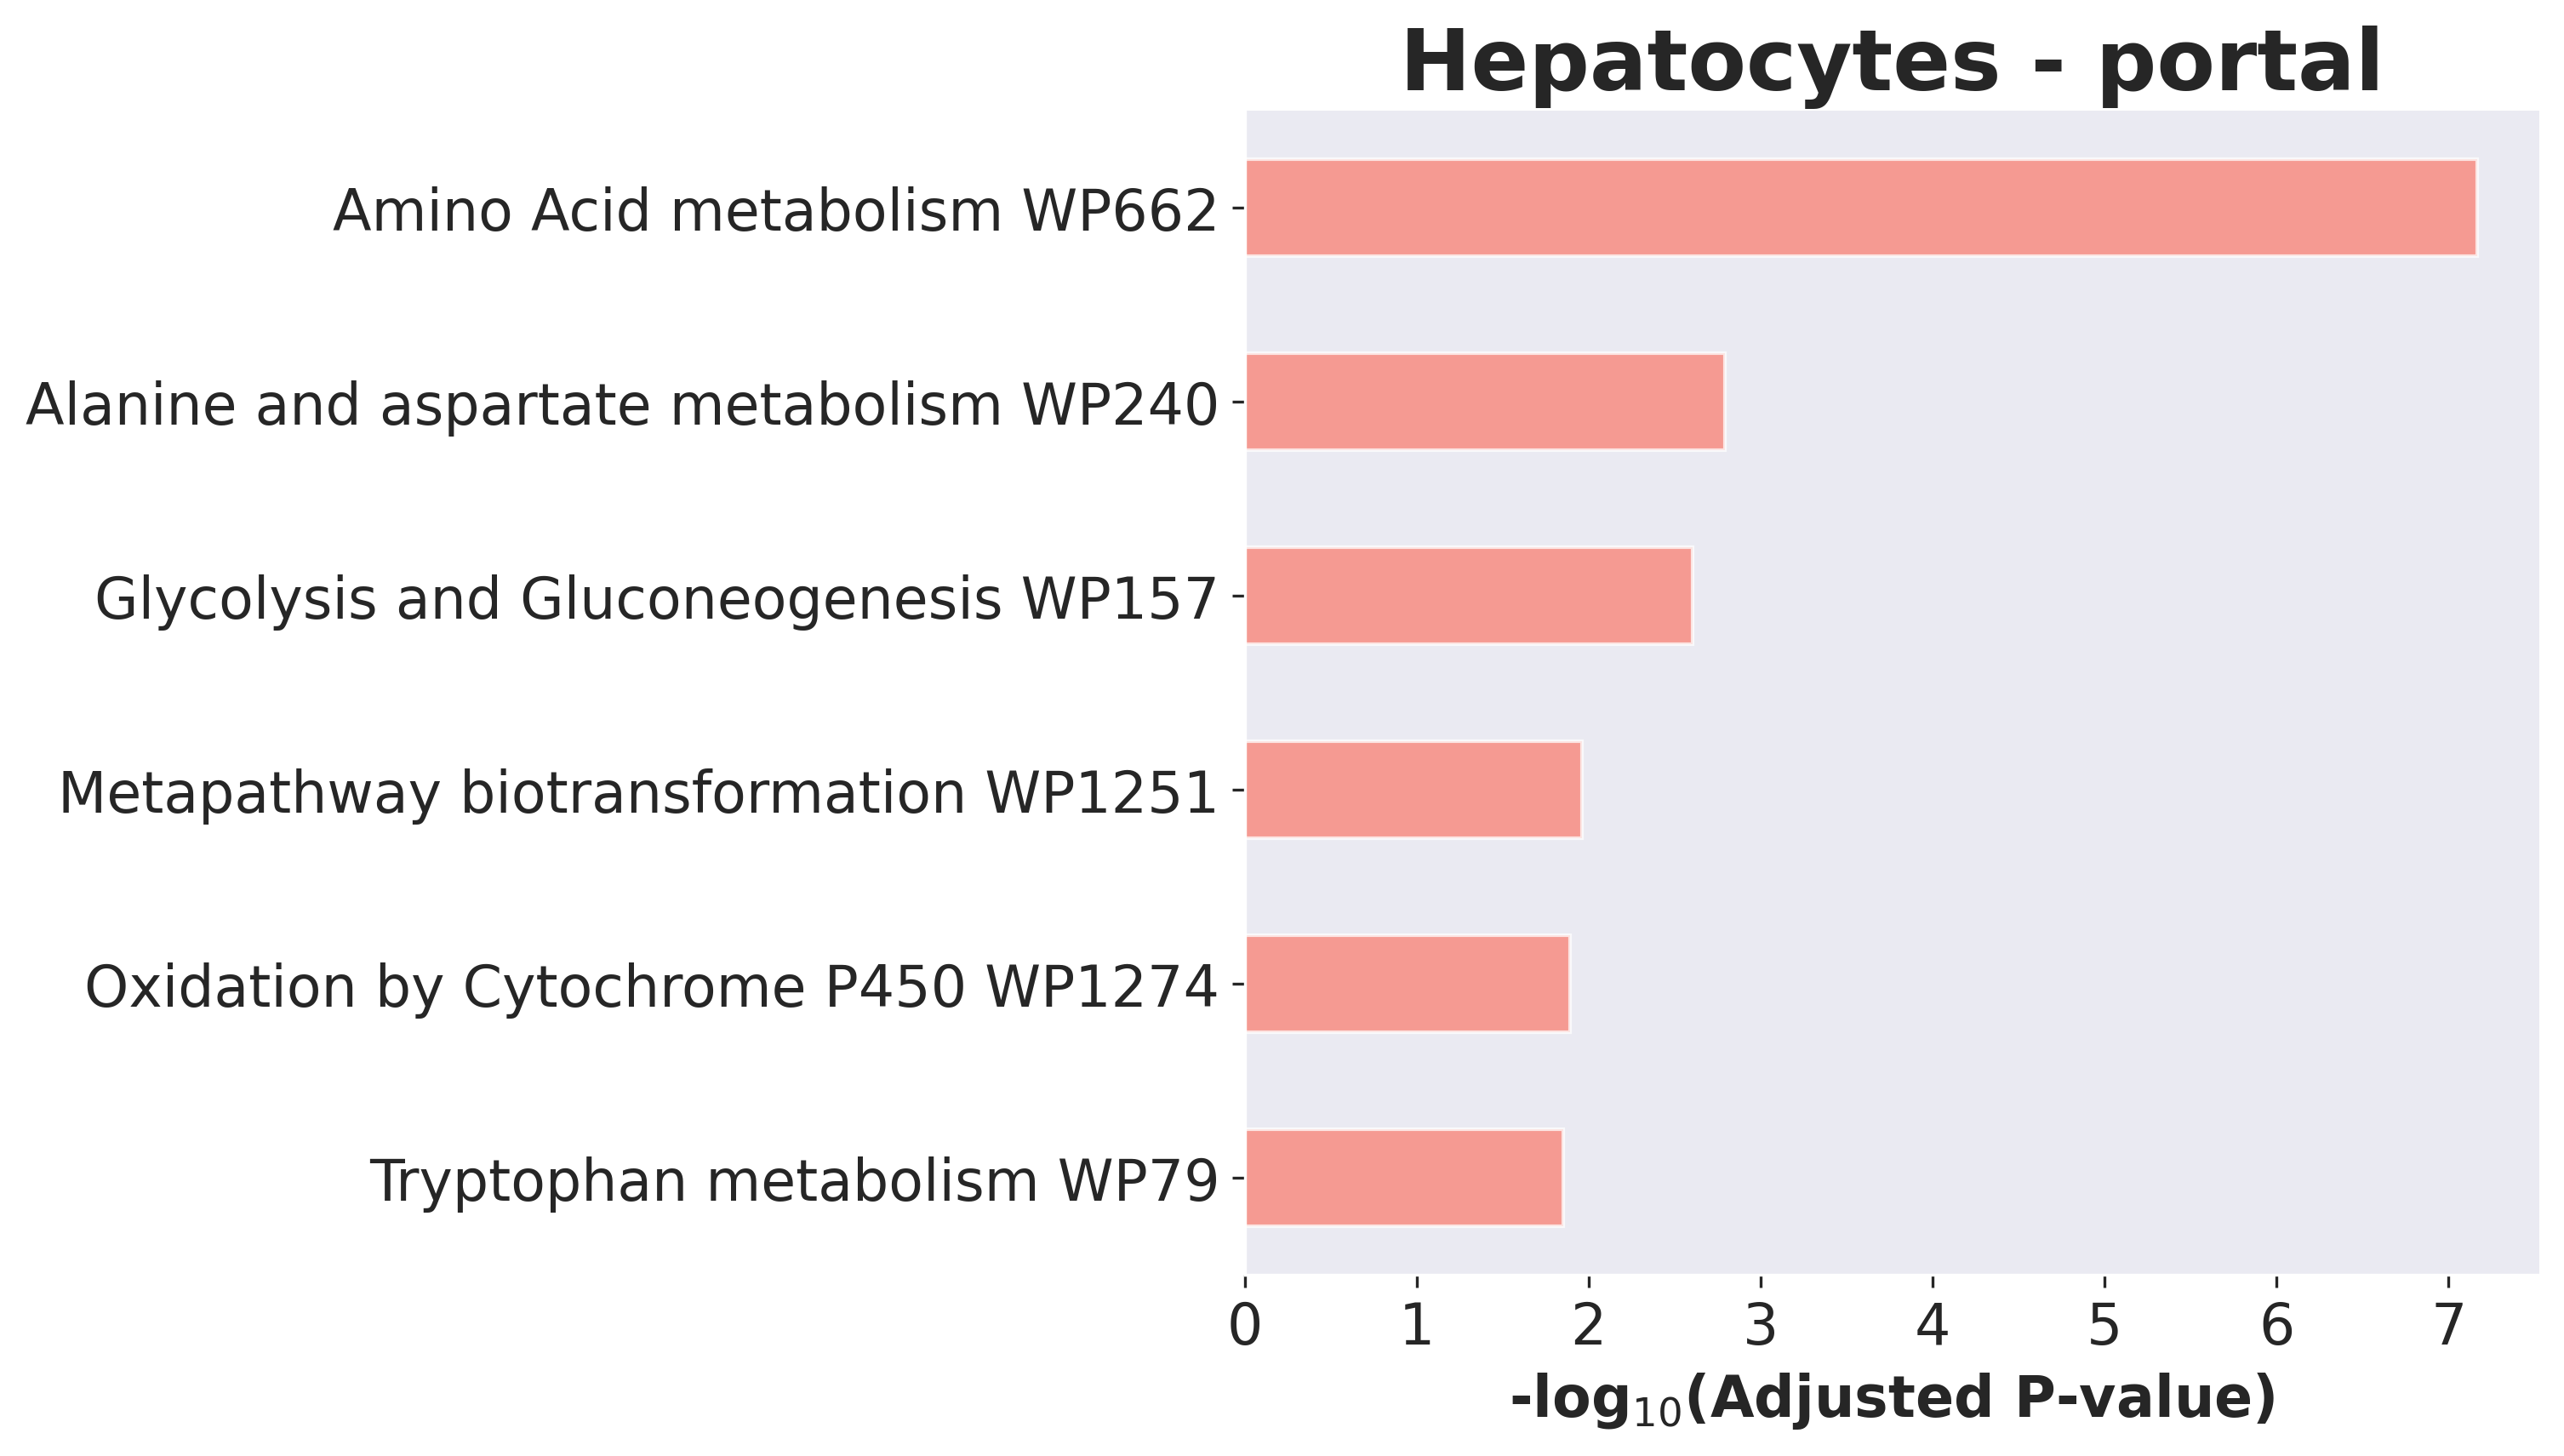

['Glis3' 'Pkhd1' 'Bicc1' 'Carmil1' 'Alcam' '2610035D17Rik' 'Naaladl2'
 'Shank2' 'Erbb4' 'Pdgfd']


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


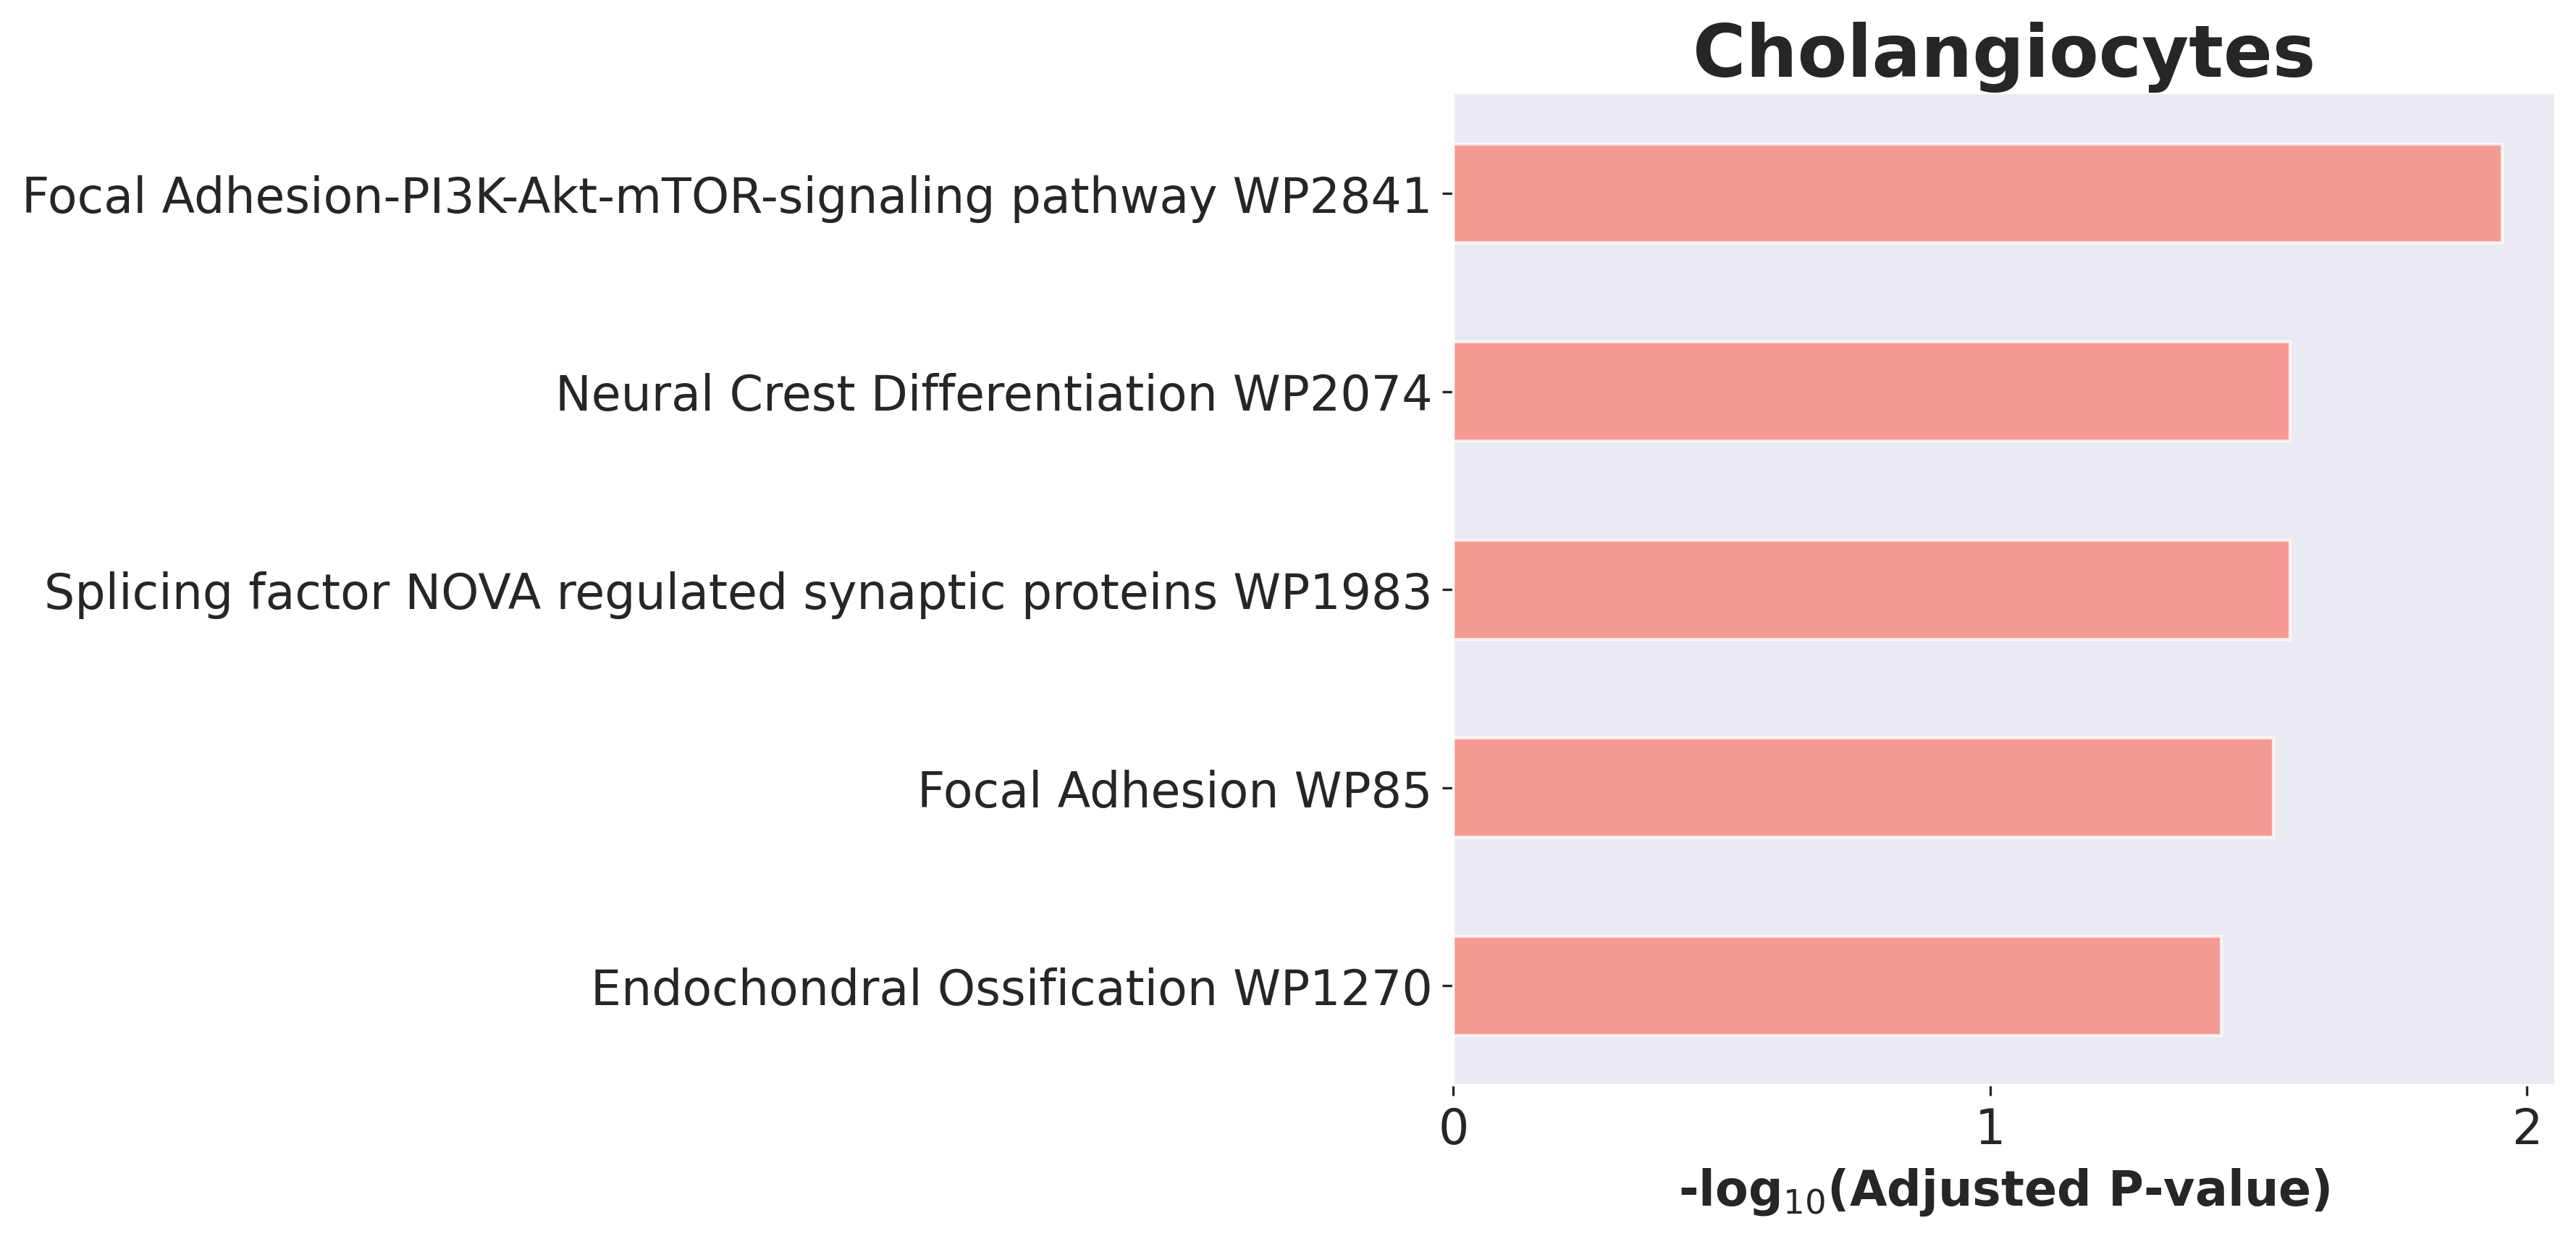

['Pde3a' 'Lhfp' 'Rbms3' 'Sox5' 'Zfpm2' 'Arhgap24' 'Gpc6' 'Cacnb2' 'Pde1a'
 'Prkg1']


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


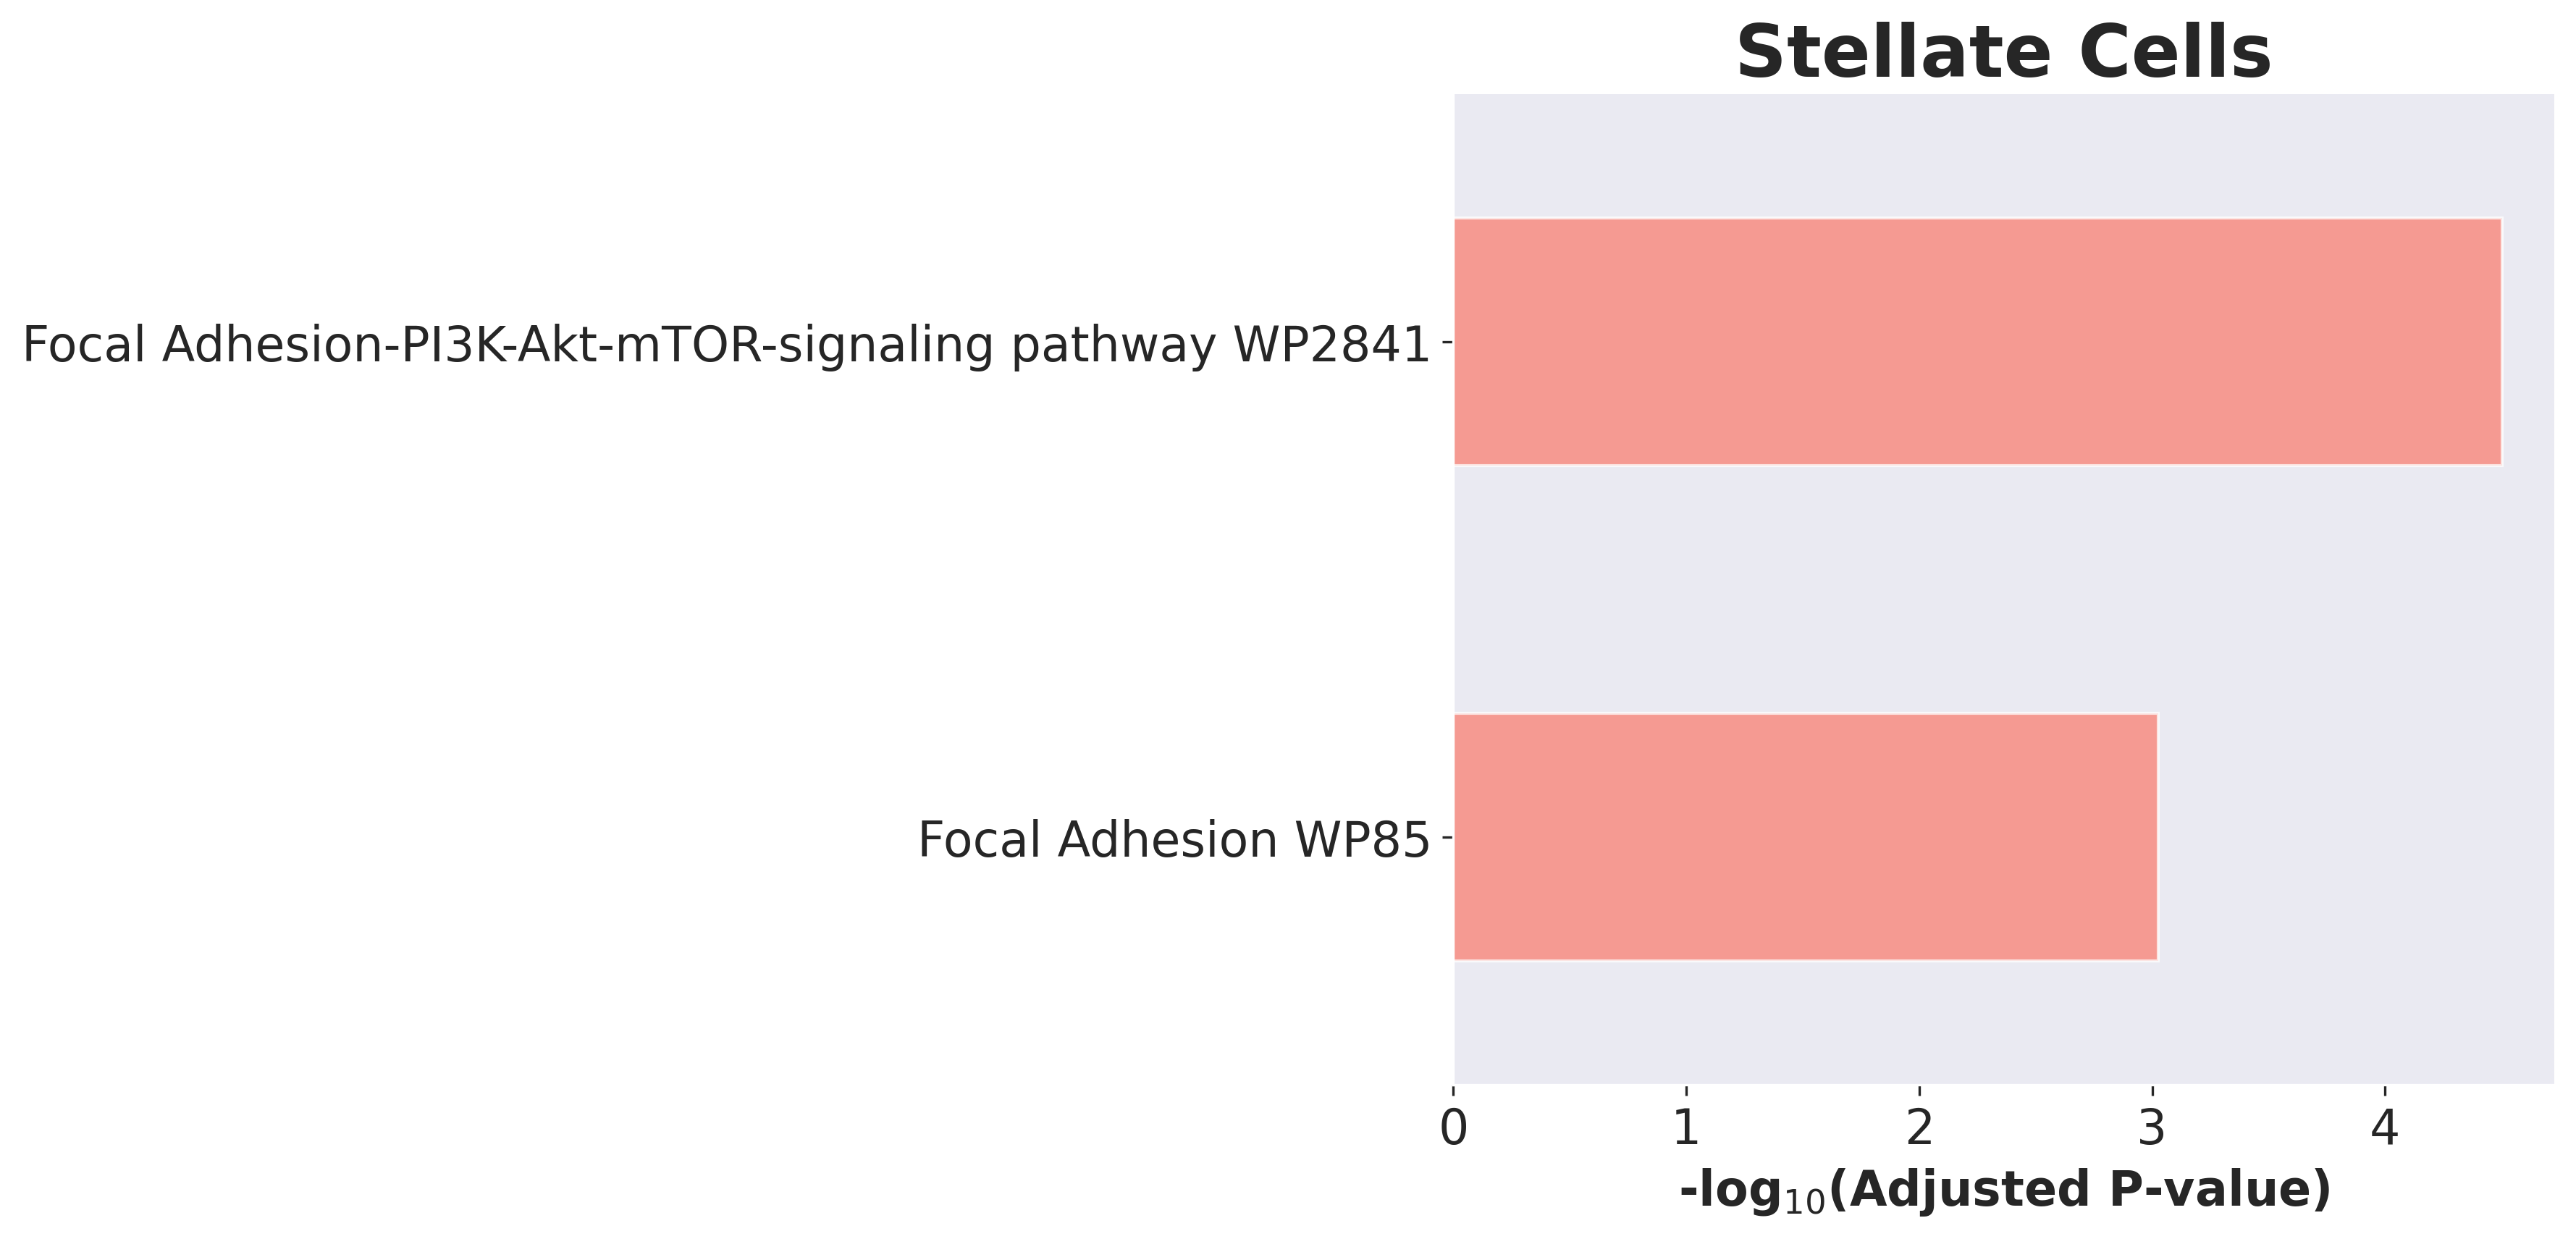

['Celf2' 'Mast4' 'Syne2' 'Efna5' 'Pcnx2' 'Thsd4' 'Wdr17' 'Gpm6a' 'Bnc2'
 'Plxna4']


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


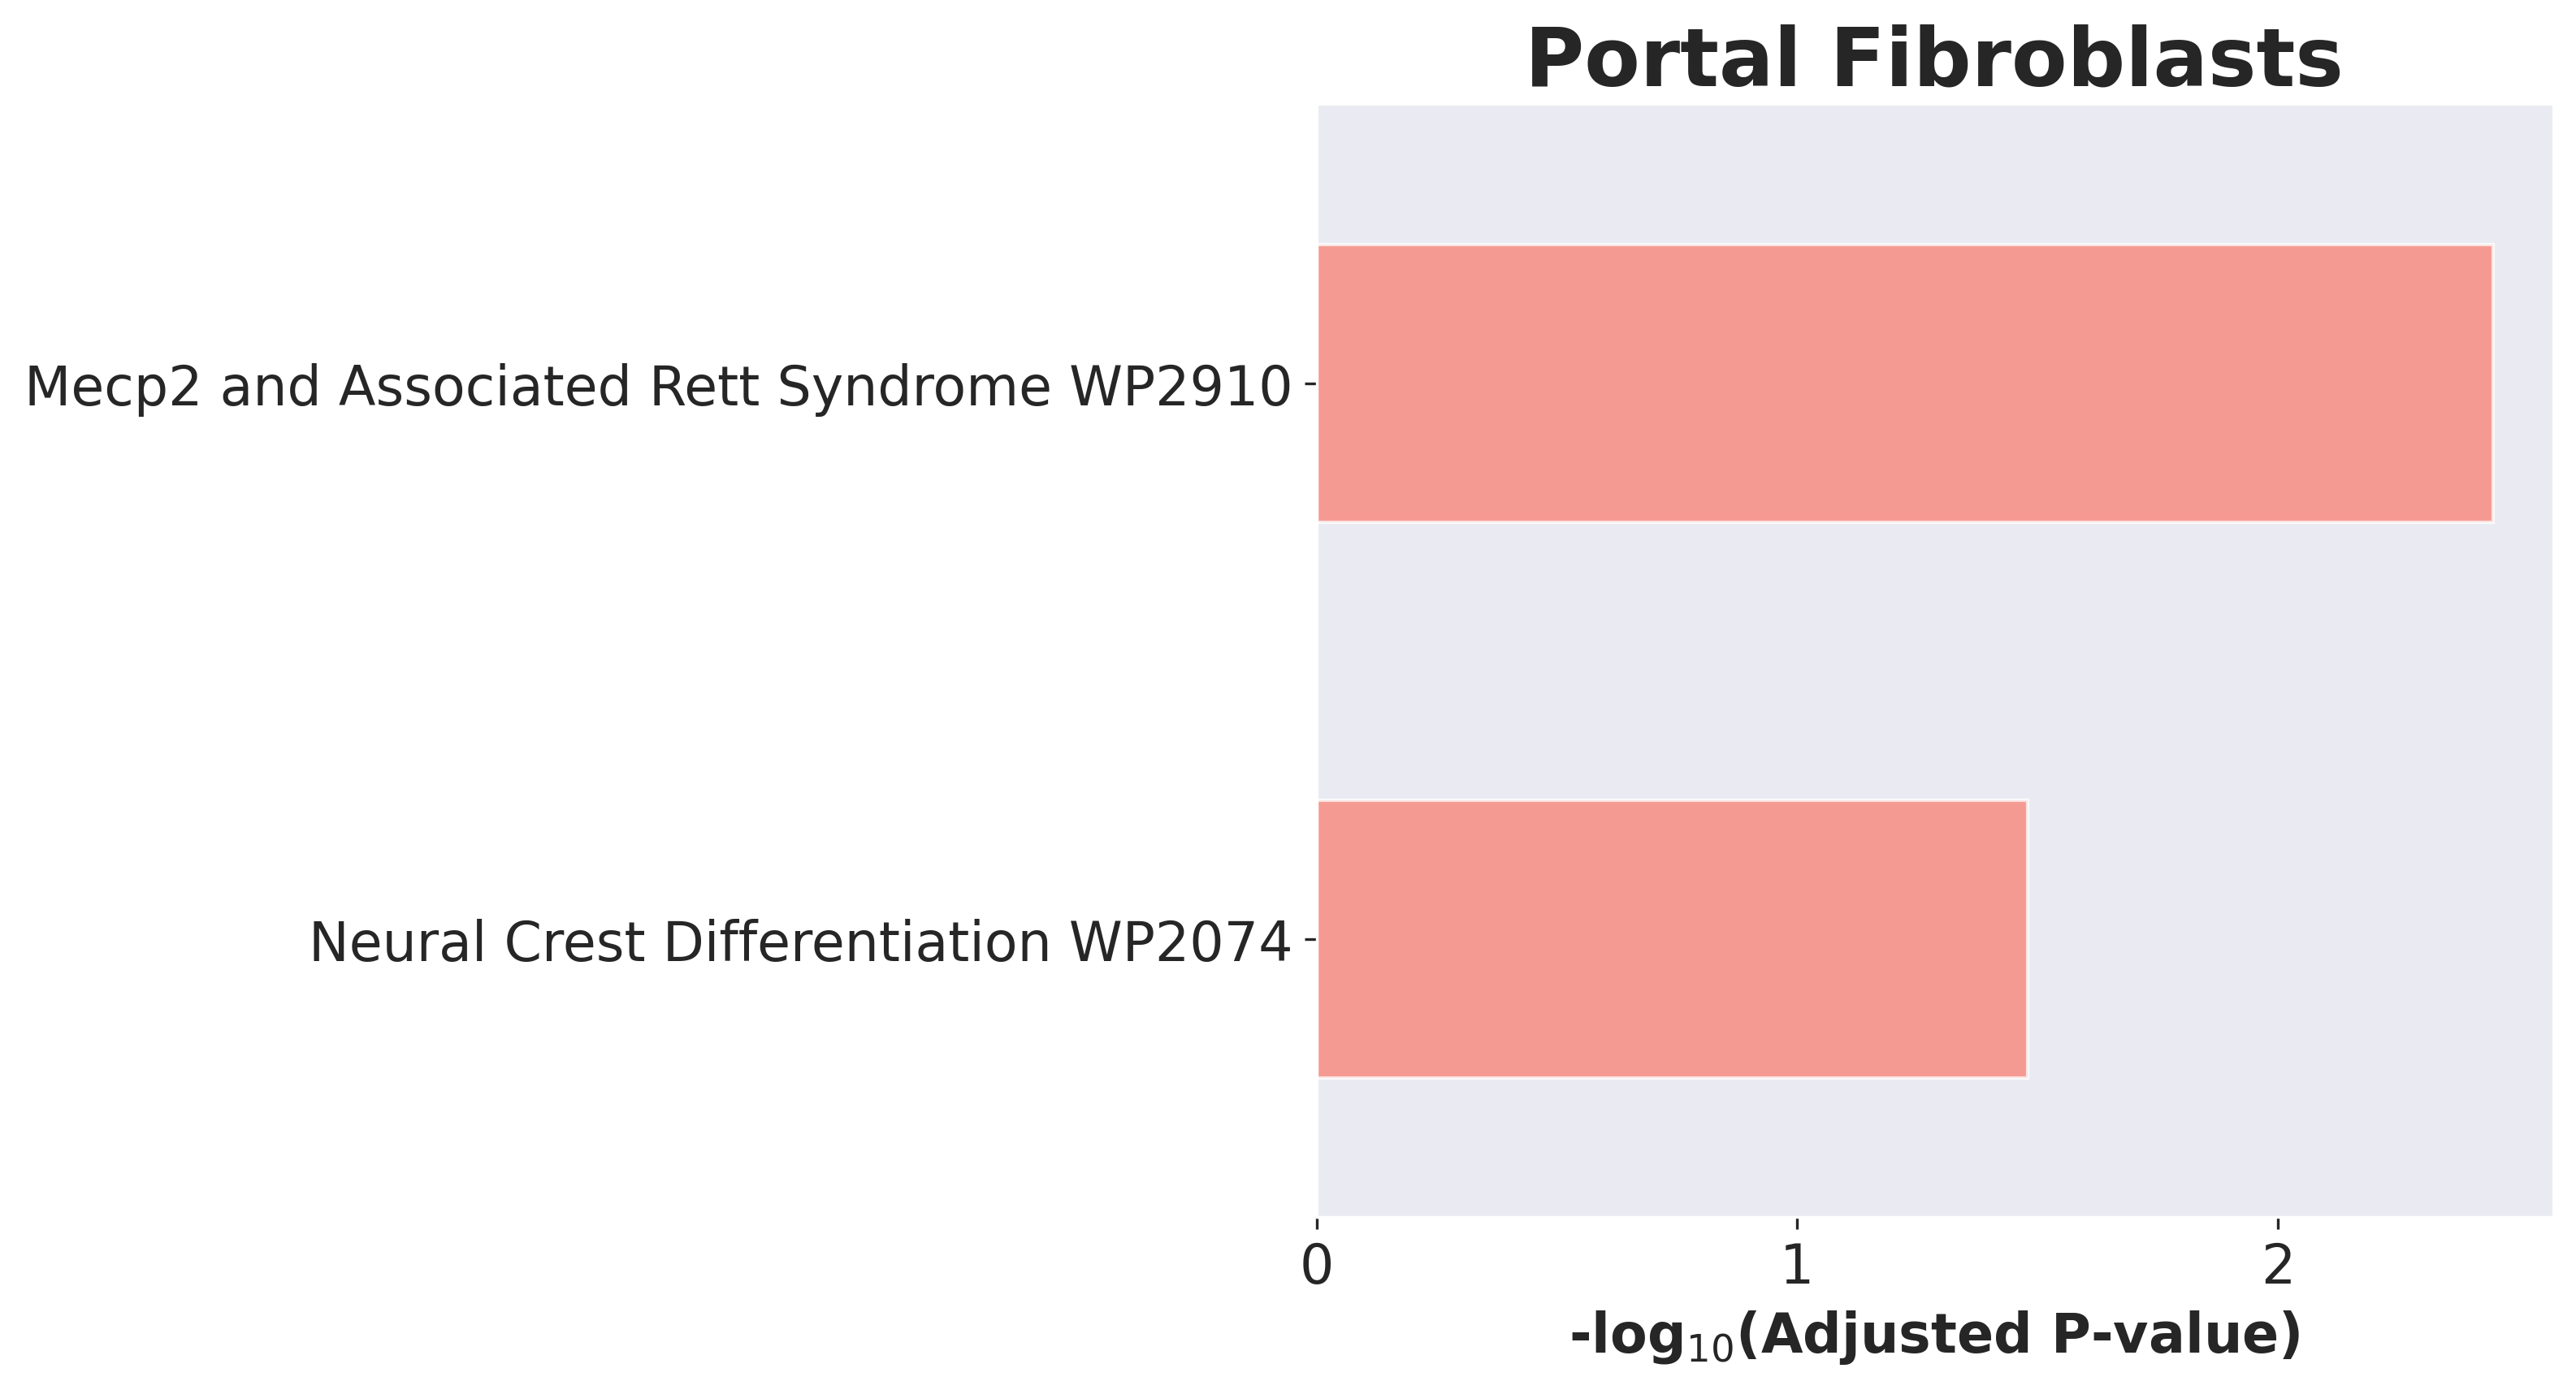

['Ptprb' 'St6galnac3' 'Plekhg1' 'Meis2' 'Plpp1' 'Arhgap31' 'Fbxl7' 'Fyn'
 'Stab2' 'Tmem2']


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


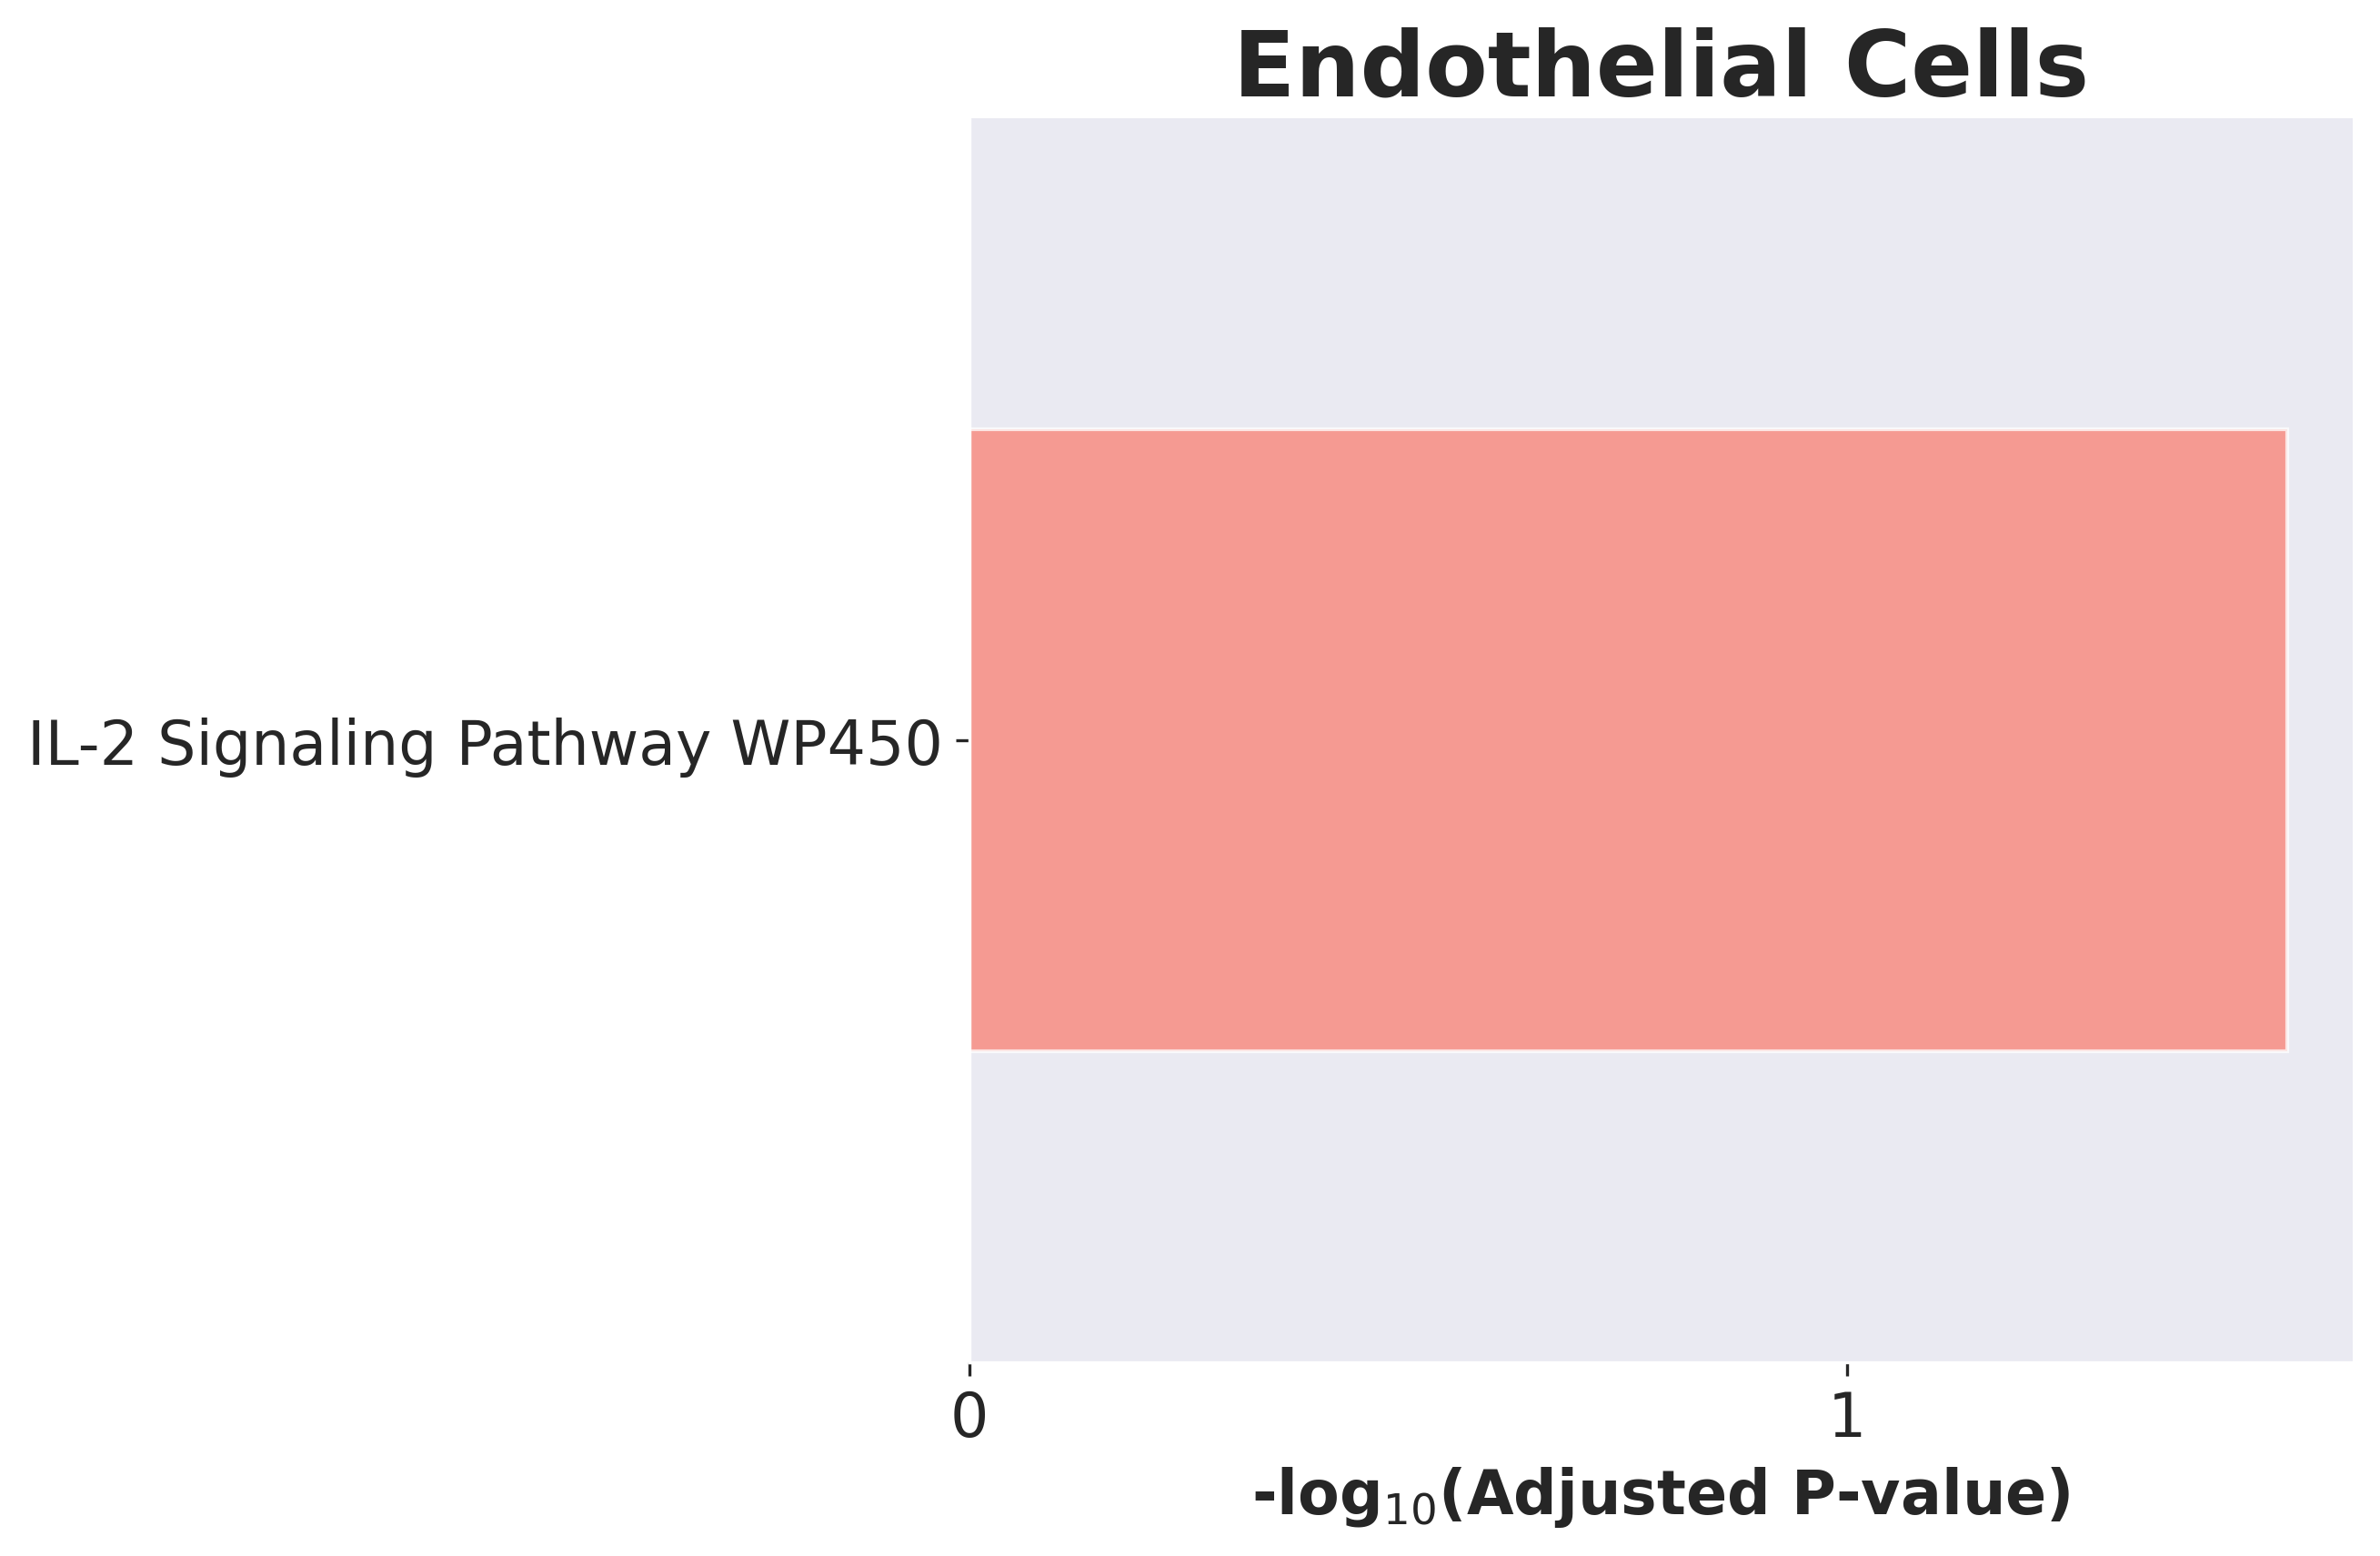

In [17]:
for cell in cell_types_of_int:
    diff_genes = CD4T.uns["rank_genes_groups"]["names"][cell]
    glist = diff_genes[:100]
    print(glist[:10])
    glist = glist.tolist()
    enr = gp.enrichr(gene_list=glist,
                     gene_sets=["WikiPathways_2019_Mouse"],
                     organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                     description='test_name',
                     outdir='test/enrichr_kegg',
                     # no_plot=True,
                     cutoff=0.5 # test dataset, use lower value from range(0,1)
                    )
    gp.plot.barplot(enr.res2d, title = f"{cell}")
    plt.show()

In [18]:
jaccard_sim = lambda x, y: len(set(x) & set(y))/len(set(x) | set(y))

In [20]:
jaccard_sim(CD4T.uns["rank_genes_groups"]["names"]["Portal Fibroblasts"][:100], CD4T.uns["rank_genes_groups"]["names"]["Cholangiocytes"][:100])

0.09289617486338798

In [33]:
N = len(cell_types_of_int)
dist_mat = np.zeros([N, N])
for i in range(N):
    for j in range(N):
        cell_i = cell_types_of_int[i]
        cell_j = cell_types_of_int[j]
        diff_i = CD4T.uns["rank_genes_groups"]["names"][cell_i][:50]
        diff_j = CD4T.uns["rank_genes_groups"]["names"][cell_j][:50]
        dist_ij = jaccard_sim(diff_i, diff_j)
        dist_mat[i, j] = dist_ij

In [34]:
dist_df = pd.DataFrame(dist_mat, columns=cell_types_of_int, index = cell_types_of_int)

<AxesSubplot:>

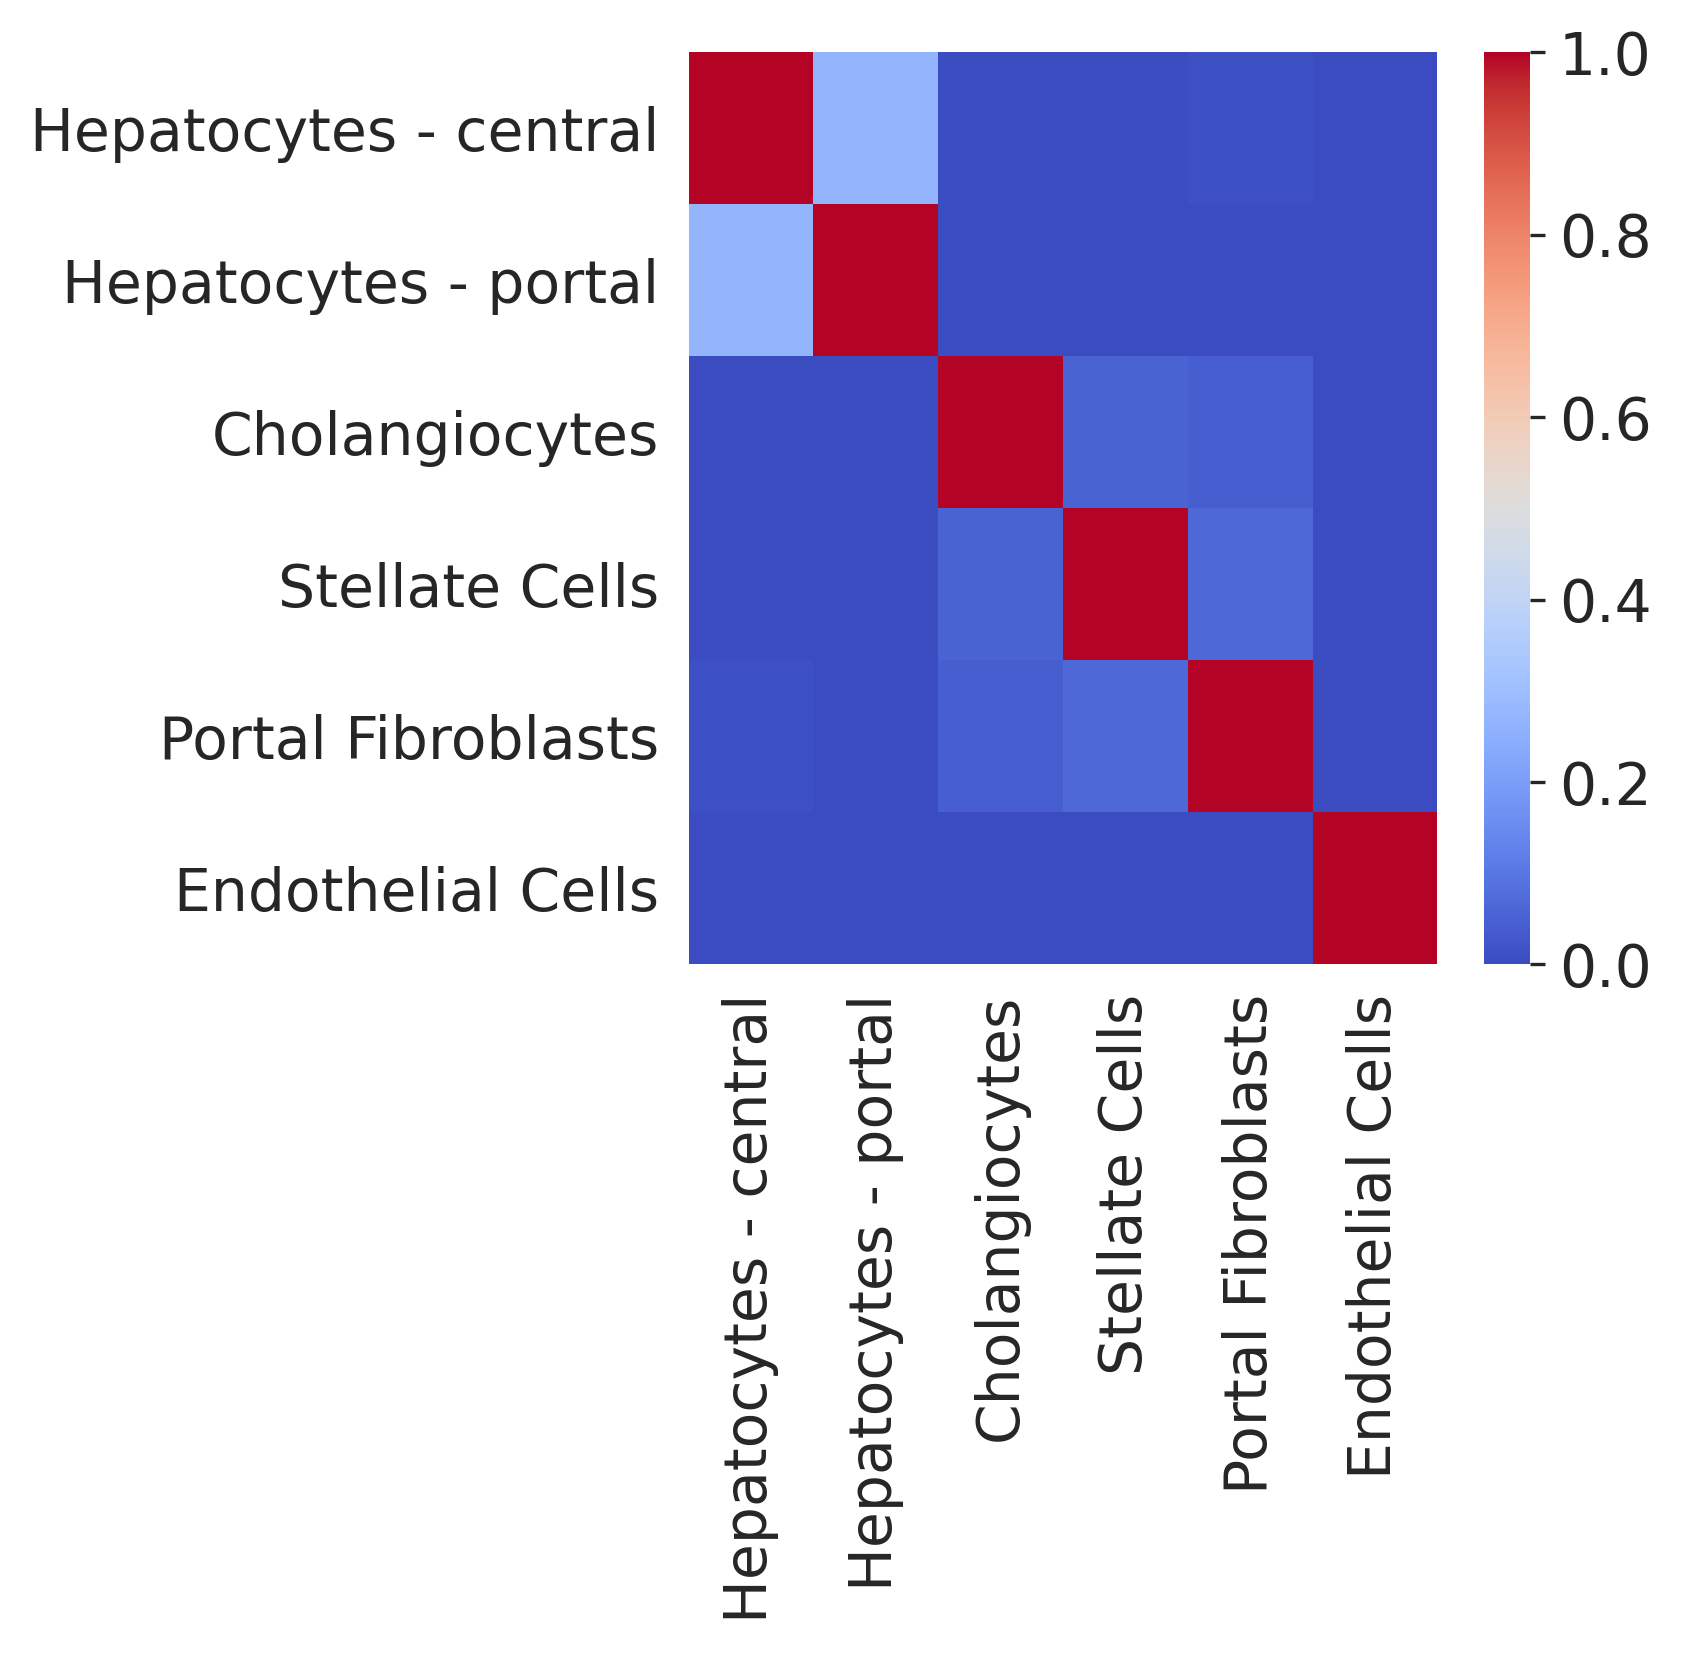

In [35]:
sns.heatmap(dist_df, cmap = "coolwarm")

In [116]:
mmd = geomloss.SamplesLoss("sinkhorn")
cos = torch.nn.CosineSimilarity(dim = 1, eps = 1e-6)

In [ ]:
for cell in cell_types_of_int:
    x = latent_adata[((adata.obs['celltype'] == cell) & (adata.obs["dose"] == "0"))]
    y = latent_adata[((adata.obs['celltype'] == cell) & (adata.obs["dose"] == "30"))]
    x_tensor = torch.Tensor(x.X)
    y_tensor = torch.Tensor(y.X)
    print(f"{cell}: {mmd(x_tensor, y_tensor)}")

Hepatocytes - central: 267.10369873046875


In [89]:
for cell in cell_types_of_int:
    x = latent_adata[((adata.obs['celltype'] == cell) & (adata.obs["dose"] == "0"))]
    y = latent_adata[((adata.obs['celltype'] == cell) & (adata.obs["dose"] == "30"))]
    np.hist(x.X)
    print(f"{cell}: {mmd(x_tensor, y_tensor)}")

torch.Size([100, 2492])

In [101]:
np.histogramdd(y.X)

ValueError: maximum supported dimension for an ndarray is 32, found 100

In [103]:
y.X

(2852, 100)